In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:

from pathlib import Path
import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from models.ranked_transformer import HsqcRankedTransformer


from datasets.optional_2d_folder_dataset import OptionalInputDataModule
import yaml
torch.set_float32_matmul_precision('medium')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")


In [ ]:
from datasets.dataset_utils import  fp_loader_configer
fp_loader_configer.select_version("MFP_Specific_Radius")
fp_loader = fp_loader_configer.fp_loader


Here we compare models' performance over 7 kinds of inputs


In [ ]:
# load model 

checkpoint_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_1d_trial_1/checkpoints/epoch=26-step=39393.ckpt"




In [ ]:
checkpoint_path = Path(checkpoint_path)
NMR_type = checkpoint_path.parts[-1].split(".")[0]

save_path = checkpoint_path.parents[1] / f"_{NMR_type}.txt"
save_path 


PosixPath('/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_1d_trial_1/_epoch=26-step=39393.txt')

In [ ]:



def show_model_performance(checkpoint_path):
    
    checkpoint_path = Path(checkpoint_path)
    
    # load path's hyperparameters
    model_path = checkpoint_path.parents[1]
    hyperpaerameters_path = model_path / "hparams.yaml"
    with open(hyperpaerameters_path, 'r') as file:
        hparams = yaml.safe_load(file)
        
    FP_building_type = hparams['FP_building_type'].split("_")[-1]
    only_2d = not hparams['use_oneD_NMR_no_solvent']
    fp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
    fp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)
    del hparams['checkpoint_path'] # prevent double defition of checkpoint_path

    # get model and datamodule
    model = HsqcRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
    model.change_ranker_for_testing()

    datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=hparams['bs'], parser_args=hparams)
    datamodule.setup("test")
    loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
    
    checkpoint_path = str(checkpoint_path)
    # select loader:
    if "only_1d" in checkpoint_path:
        loader = loader_only_1d
    # elif checkpoint_path.contains("only_H_NMR") or checkpoint_path.contains("only_h"):
    elif "only_H_NMR" in checkpoint_path or "only_h" in checkpoint_path:
        loader = loader_only_H_NMR
    # elif checkpoint_path.contains("only_C_NMR") or checkpoint_path.contains("only_c"):
    elif "only_C_NMR" in checkpoint_path or "only_c" in checkpoint_path:
        loader = loader_only_C_NMR
    # elif checkpoint_path.contains("only_HSQC") or checkpoint_path.contains("only_hsqc"):
    elif "only_HSQC" in checkpoint_path or "only_hsqc" in checkpoint_path:
        loader = loader_only_hsqc
    # elif checkpoint_path.contains("HSQC_H_NMR") or checkpoint_path.contains("HSQC_and_H"):
    elif "HSQC_H_NMR" in checkpoint_path or "HSQC_and_H" in checkpoint_path:
        loader = loader_HSQC_H_NMR
    # elif checkpoint_path.contains("HSQC_C_NMR") or checkpoint_path.contains("HSQC_and_C"):
    elif "HSQC_C_NMR" in checkpoint_path or "HSQC_and_C" in checkpoint_path:
        loader = loader_HSQC_C_NMR
    # elif checkpoint_path.contains("all_inputs"):
    elif "all_inputs" in checkpoint_path:
        loader = loader_all_inputs
    else:
        raise ValueError("Invalid checkpoint path")
    trainer = Trainer()
    result =  trainer.test(model, dataloaders=loader) 
           
    return {k.split("/")[-1]:v for k,v in result[0].items() if "rank_1_of_NP_class" in k}

In [ ]:
# result = show_model_performance(str(checkpoint_path))
# checkpoint_path = Path(checkpoint_path)


In [ ]:
import os
paths_to_run_NP_classes_ranking = []

flexible_dir = Path("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/flexible_models_best_FP")
for trial in os.listdir(flexible_dir):
    dir = flexible_dir / trial
    for ckpt in os.listdir(dir/ "checkpoints"):
        paths_to_run_NP_classes_ranking.append(dir/ "checkpoints" / ckpt)
        
specified_model_dir = Path("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible")
for trial in os.listdir(specified_model_dir):
    dir = specified_model_dir / trial
    for ckpt in os.listdir(dir/ "checkpoints"):
        if ckpt.startswith("epoch"):
            paths_to_run_NP_classes_ranking.append(dir/ "checkpoints" / ckpt)
        
    

In [ ]:
import pickle
for checkpoint_path in paths_to_run_NP_classes_ranking:
    checkpoint_path = Path(checkpoint_path)
    NMR_type = checkpoint_path.parts[-1].split(".")[0]
    save_path = checkpoint_path.parents[1] / f"NP_class_accu_{NMR_type}.pkl"
    result = show_model_performance(str(checkpoint_path))
    with open(save_path, 'wb') as file:
        pickle.dump(result, file)
    

loading time: 32.686787605285645
counting time: 14.68679428100586
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930438995361328                   │
│                 test/mean_active_bits                  │                     85.36669921875                     │
│                   test/mean_ce_loss                    │                  0.025722157210111618                  │
│                     test/mean_cos                      │                   0.770699679851532                    │
│                      test/mean_f1                      │                   0.7740612030029297                   │
│                   test/mean_jaccard                    │                   0.6375353336334229                   │
│                  test/mean_mean_rank                   │                   27.79386329650879                    │
│                   test/mean_neg_loss                   │                  0.007728893775492907                  │
│                   test/mean_pos_loss                   │                    0.01799326390028                    │
│                 test/mean_pos_neg_loss                 │                  0.025722159072756767                  │
│                  test/mean_precision                   │                   0.8612397909164429                   │
│                    test/mean_rank_1                    │                   0.6211751103401184                   │
│                   test/mean_rank_10                    │                   0.8641764521598816                   │
│                    test/mean_rank_5                    │                   0.8163248896598816                   │
│                    test/mean_recall                    │                   0.7035666704177856                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.1666666716337204                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.34375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.4545454680919647                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.5483871102333069                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7888888716697693                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6415094137191772                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6818181872367859                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.2151644229888916
counting time: 15.755461692810059
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9961140751838684                   │
│                 test/mean_active_bits                  │                   98.68741607666016                    │
│                   test/mean_ce_loss                    │                  0.01773799955844879                   │
│                     test/mean_cos                      │                   0.874854564666748                    │
│                      test/mean_f1                      │                   0.8813285827636719                   │
│                   test/mean_jaccard                    │                   0.7909745573997498                   │
│                  test/mean_mean_rank                   │                   4.027669429779053                    │
│                   test/mean_neg_loss                   │                  0.005482093431055546                  │
│                   test/mean_pos_loss                   │                  0.012255906127393246                  │
│                 test/mean_pos_neg_loss                 │                  0.01773799955844879                   │
│                  test/mean_precision                   │                   0.9079554677009583                   │
│                    test/mean_rank_1                    │                     0.906494140625                     │
│                   test/mean_rank_10                    │                     0.98388671875                      │
│                    test/mean_rank_5                    │                     0.97802734375                      │
│                    test/mean_recall                    │                   0.8563850522041321                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.8125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8627451062202454                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8709677457809448                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8679245114326477                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.838064432144165
counting time: 15.727431297302246
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930316805839539                   │
│                 test/mean_active_bits                  │                   88.45125579833984                    │
│                   test/mean_ce_loss                    │                  0.029047733172774315                  │
│                     test/mean_cos                      │                   0.7725109457969666                   │
│                      test/mean_f1                      │                   0.7772667407989502                   │
│                   test/mean_jaccard                    │                    0.64315265417099                    │
│                  test/mean_mean_rank                   │                   27.84700584411621                    │
│                   test/mean_neg_loss                   │                  0.008706937544047832                  │
│                   test/mean_pos_loss                   │                  0.020340796560049057                  │
│                 test/mean_pos_neg_loss                 │                  0.029047733172774315                  │
│                  test/mean_precision                   │                   0.8482754230499268                   │
│                    test/mean_rank_1                    │                   0.6381022334098816                   │
│                   test/mean_rank_10                    │                     0.868408203125                     │
│                    test/mean_rank_5                    │                     0.821533203125                     │
│                    test/mean_recall                    │                   0.7176672220230103                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.4375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5151515007019043                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.7419354915618896                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7333333492279053                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5471698045730591                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6818181872367859                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          0.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.955840587615967
counting time: 15.46465253829956
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9961731433868408                   │
│                 test/mean_active_bits                  │                     94.4384765625                      │
│                   test/mean_ce_loss                    │                  0.015192358754575253                  │
│                     test/mean_cos                      │                   0.8747375011444092                   │
│                      test/mean_f1                      │                   0.8808095455169678                   │
│                   test/mean_jaccard                    │                   0.7884426116943359                   │
│                  test/mean_mean_rank                   │                     4.585205078125                     │
│                   test/mean_neg_loss                   │                  0.004172735847532749                  │
│                   test/mean_pos_loss                   │                  0.011019622907042503                  │
│                 test/mean_pos_neg_loss                 │                  0.015192358754575253                  │
│                  test/mean_precision                   │                   0.928377628326416                    │
│                    test/mean_rank_1                    │                      0.9111328125                      │
│                   test/mean_rank_10                    │                     0.984619140625                     │
│                    test/mean_rank_5                    │                     0.97607421875                      │
│                    test/mean_recall                    │                   0.8382875919342041                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.875                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9245283007621765                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.113595485687256
counting time: 15.89783239364624
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9969264268875122                   │
│                 test/mean_active_bits                  │                   98.50894927978516                    │
│                   test/mean_ce_loss                    │                  0.013267289847135544                  │
│                     test/mean_cos                      │                   0.9010401368141174                   │
│                      test/mean_f1                      │                   0.9061042666435242                   │
│                   test/mean_jaccard                    │                   0.8298832178115845                   │
│                  test/mean_mean_rank                   │                   2.7733561992645264                   │
│                   test/mean_neg_loss                   │                 0.0037420967128127813                  │
│                   test/mean_pos_loss                   │                  0.009525193832814693                  │
│                 test/mean_pos_neg_loss                 │                  0.013267289847135544                  │
│                  test/mean_precision                   │                   0.9342270493507385                   │
│                    test/mean_rank_1                    │                   0.9435221552848816                   │
│                   test/mean_rank_10                    │                     0.993896484375                     │
│                    test/mean_rank_5                    │                     0.989013671875                     │
│                    test/mean_recall                    │                   0.8797658085823059                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9777777791023254                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.089674234390259
counting time: 15.42030382156372
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9955791234970093                   │
│                 test/mean_active_bits                  │                   94.82389068603516                    │
│                   test/mean_ce_loss                    │                  0.019718695431947708                  │
│                     test/mean_cos                      │                   0.8541911840438843                   │
│                      test/mean_f1                      │                   0.8625844120979309                   │
│                   test/mean_jaccard                    │                   0.7608202695846558                   │
│                  test/mean_mean_rank                   │                   14.785969734191895                   │
│                   test/mean_neg_loss                   │                  0.005667556077241898                  │
│                   test/mean_pos_loss                   │                  0.01405113935470581                   │
│                 test/mean_pos_neg_loss                 │                  0.019718695431947708                  │
│                  test/mean_precision                   │                   0.9072276949882507                   │
│                    test/mean_rank_1                    │                   0.8797200322151184                   │
│                   test/mean_rank_10                    │                       0.96484375                       │
│                    test/mean_rank_5                    │                     0.954345703125                     │
│                    test/mean_recall                    │                   0.8224831223487854                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.71875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.843137264251709                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9090909361839294                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9032257795333862                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8888888955116272                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8181818127632141                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.313533067703247
counting time: 14.52163028717041
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9967784881591797                   │
│                 test/mean_active_bits                  │                     98.55224609375                     │
│                   test/mean_ce_loss                    │                  0.01484121847897768                   │
│                     test/mean_cos                      │                   0.8957895636558533                   │
│                      test/mean_f1                      │                   0.9016464948654175                   │
│                   test/mean_jaccard                    │                   0.8222836256027222                   │
│                  test/mean_mean_rank                   │                   1.8260904550552368                   │
│                   test/mean_neg_loss                   │                  0.00415100296959281                   │
│                   test/mean_pos_loss                   │                  0.010690215975046158                  │
│                 test/mean_pos_neg_loss                 │                  0.01484121847897768                   │
│                  test/mean_precision                   │                   0.9295544624328613                   │
│                    test/mean_rank_1                    │                   0.9358723759651184                   │
│                   test/mean_rank_10                    │                     0.99072265625                      │
│                    test/mean_rank_5                    │                     0.987060546875                     │
│                    test/mean_recall                    │                   0.8755090832710266                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9777777791023254                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.317490339279175
counting time: 14.976672887802124
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9834170341491699                   │
│                 test/mean_active_bits                  │                     179.552734375                      │
│                   test/mean_ce_loss                    │                  0.06926865130662918                   │
│                     test/mean_cos                      │                   0.7416771650314331                   │
│                      test/mean_f1                      │                   0.7478614449501038                   │
│                   test/mean_jaccard                    │                   0.5983192920684814                   │
│                  test/mean_mean_rank                   │                   23.35188865661621                    │
│                   test/mean_neg_loss                   │                  0.020165931433439255                  │
│                   test/mean_pos_loss                   │                  0.04910271614789963                   │
│                 test/mean_pos_neg_loss                 │                  0.06926864385604858                   │
│                  test/mean_precision                   │                   0.8502569794654846                   │
│                    test/mean_rank_1                    │                   0.6348469853401184                   │
│                   test/mean_rank_10                    │                   0.8826497197151184                   │
│                    test/mean_rank_5                    │                   0.8411458134651184                   │
│                    test/mean_recall                    │                   0.6680400967597961                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.5625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7254902124404907                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                  0.42424243688583374                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.4838709533214569                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7888888716697693                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5849056839942932                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.7272727489471436                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.2113258838653564
counting time: 14.283009767532349
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9900617003440857                   │
│                 test/mean_active_bits                  │                   198.3324432373047                    │
│                   test/mean_ce_loss                    │                  0.04034169018268585                   │
│                     test/mean_cos                      │                   0.8448647260665894                   │
│                      test/mean_f1                      │                   0.8544397950172424                   │
│                   test/mean_jaccard                    │                   0.7393940687179565                   │
│                  test/mean_mean_rank                   │                   1.6136881113052368                   │
│                   test/mean_neg_loss                   │                  0.011406226083636284                  │
│                   test/mean_pos_loss                   │                  0.028935464099049568                  │
│                 test/mean_pos_neg_loss                 │                  0.04034169018268585                   │
│                  test/mean_precision                   │                   0.9204666018486023                   │
│                    test/mean_rank_1                    │                   0.8993327021598816                   │
│                   test/mean_rank_10                    │                     0.98583984375                      │
│                    test/mean_rank_5                    │                     0.977783203125                     │
│                    test/mean_recall                    │                   0.7977533936500549                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.875                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.7419354915618896                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9111111164093018                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.2564070224761963
counting time: 14.535251140594482
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9914413094520569                   │
│                 test/mean_active_bits                  │                   201.0792694091797                    │
│                   test/mean_ce_loss                    │                  0.03530798852443695                   │
│                     test/mean_cos                      │                   0.8673117756843567                   │
│                      test/mean_f1                      │                   0.8753641843795776                   │
│                   test/mean_jaccard                    │                    0.77195143699646                    │
│                  test/mean_mean_rank                   │                   0.4063313901424408                   │
│                   test/mean_neg_loss                   │                  0.009611180052161217                  │
│                   test/mean_pos_loss                   │                  0.025696806609630585                  │
│                 test/mean_pos_neg_loss                 │                  0.03530798852443695                   │
│                  test/mean_precision                   │                   0.9359926581382751                   │
│                    test/mean_rank_1                    │                   0.9407551884651184                   │
│                   test/mean_rank_10                    │                      0.994140625                       │
│                    test/mean_rank_5                    │                     0.98974609375                      │
│                    test/mean_recall                    │                   0.822537899017334                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9803921580314636                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9555555582046509                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.230989694595337
counting time: 14.42299222946167
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9916514158248901                   │
│                 test/mean_active_bits                  │                    201.79443359375                     │
│                   test/mean_ce_loss                    │                   0.0349481999874115                   │
│                     test/mean_cos                      │                   0.8712493181228638                   │
│                      test/mean_f1                      │                   0.8787575960159302                   │
│                   test/mean_jaccard                    │                   0.7777576446533203                   │
│                  test/mean_mean_rank                   │                   0.4285481870174408                   │
│                   test/mean_neg_loss                   │                  0.009460266679525375                  │
│                   test/mean_pos_loss                   │                  0.025487931445240974                  │
│                 test/mean_pos_neg_loss                 │                   0.0349481962621212                   │
│                  test/mean_precision                   │                   0.9377778768539429                   │
│                    test/mean_rank_1                    │                   0.9429524540901184                   │
│                   test/mean_rank_10                    │                     0.995361328125                     │
│                    test/mean_rank_5                    │                     0.990478515625                     │
│                    test/mean_recall                    │                   0.827111005783081                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9444444179534912                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.573442220687866
counting time: 13.888765335083008
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9835028052330017                   │
│                 test/mean_active_bits                  │                   176.5309295654297                    │
│                   test/mean_ce_loss                    │                  0.06449088454246521                   │
│                     test/mean_cos                      │                   0.7423226237297058                   │
│                      test/mean_f1                      │                   0.7472644448280334                   │
│                   test/mean_jaccard                    │                   0.5971567630767822                   │
│                  test/mean_mean_rank                   │                     21.78466796875                     │
│                   test/mean_neg_loss                   │                  0.018886148929595947                  │
│                   test/mean_pos_loss                   │                  0.04560473561286926                   │
│                 test/mean_pos_neg_loss                 │                  0.06449088454246521                   │
│                  test/mean_precision                   │                   0.8577169179916382                   │
│                    test/mean_rank_1                    │                     0.639404296875                     │
│                   test/mean_rank_10                    │                     0.885009765625                     │
│                    test/mean_rank_5                    │                      0.8369140625                      │
│                    test/mean_recall                    │                   0.6626841425895691                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.5625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7254902124404907                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.4848484992980957                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.5483871102333069                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8222222328186035                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6037735939025879                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6363636255264282                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.833996534347534
counting time: 14.557197332382202
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.989098310470581                    │
│                 test/mean_active_bits                  │                   189.1145782470703                    │
│                   test/mean_ce_loss                    │                  0.044766172766685486                  │
│                     test/mean_cos                      │                   0.8261888027191162                   │
│                      test/mean_f1                      │                   0.8366576433181763                   │
│                   test/mean_jaccard                    │                   0.7119192481040955                   │
│                  test/mean_mean_rank                   │                     7.344482421875                     │
│                   test/mean_neg_loss                   │                  0.011514775454998016                  │
│                   test/mean_pos_loss                   │                  0.03325139731168747                   │
│                 test/mean_pos_neg_loss                 │                  0.044766172766685486                  │
│                  test/mean_precision                   │                   0.9247137904167175                   │
│                    test/mean_rank_1                    │                   0.8789876103401184                   │
│                   test/mean_rank_10                    │                   0.9737141728401184                   │
│                    test/mean_rank_5                    │                   0.9637044072151184                   │
│                    test/mean_recall                    │                   0.7646497488021851                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.78125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.875                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9607843160629272                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8484848737716675                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8999999761581421                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8301886916160583                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.789888381958008
counting time: 14.37496280670166
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9901624321937561                   │
│                 test/mean_active_bits                  │                   191.7642364501953                    │
│                   test/mean_ce_loss                    │                   0.0399000458419323                   │
│                     test/mean_cos                      │                   0.8454982042312622                   │
│                      test/mean_f1                      │                   0.8537586331367493                   │
│                   test/mean_jaccard                    │                   0.738249659538269                    │
│                  test/mean_mean_rank                   │                   2.0576984882354736                   │
│                   test/mean_neg_loss                   │                  0.010078873485326767                  │
│                   test/mean_pos_loss                   │                  0.02982117049396038                   │
│                 test/mean_pos_neg_loss                 │                   0.0399000458419323                   │
│                  test/mean_precision                   │                   0.9364606738090515                   │
│                    test/mean_rank_1                    │                   0.9146321415901184                   │
│                   test/mean_rank_10                    │                     0.98486328125                      │
│                    test/mean_rank_5                    │                   0.9783528447151184                   │
│                    test/mean_recall                    │                   0.7851482629776001                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9607843160629272                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8181818127632141                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.786625385284424
counting time: 14.313655853271484
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9901019930839539                   │
│                 test/mean_active_bits                  │                    192.835205078125                    │
│                   test/mean_ce_loss                    │                  0.03896106779575348                   │
│                     test/mean_cos                      │                   0.8460825085639954                   │
│                      test/mean_f1                      │                   0.8532858490943909                   │
│                   test/mean_jaccard                    │                   0.7388174533843994                   │
│                  test/mean_mean_rank                   │                     2.515380859375                     │
│                   test/mean_neg_loss                   │                  0.010844763368368149                  │
│                   test/mean_pos_loss                   │                  0.02811630256474018                   │
│                 test/mean_pos_neg_loss                 │                  0.03896106779575348                   │
│                  test/mean_precision                   │                   0.9330012798309326                   │
│                    test/mean_rank_1                    │                   0.9138997197151184                   │
│                   test/mean_rank_10                    │                   0.9890950322151184                   │
│                    test/mean_rank_5                    │                   0.9810383915901184                   │
│                    test/mean_recall                    │                   0.7867997288703918                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.78125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9607843160629272                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8484848737716675                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9777777791023254                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8636363744735718                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.6842164993286133
counting time: 13.242203712463379
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.991356372833252                    │
│                 test/mean_active_bits                  │                    199.513427734375                    │
│                   test/mean_ce_loss                    │                  0.03618492931127548                   │
│                     test/mean_cos                      │                   0.8661394715309143                   │
│                      test/mean_f1                      │                   0.8737287521362305                   │
│                   test/mean_jaccard                    │                   0.7700865864753723                   │
│                  test/mean_mean_rank                   │                     1.23095703125                      │
│                   test/mean_neg_loss                   │                  0.00915880873799324                   │
│                   test/mean_pos_loss                   │                  0.027026118710637093                  │
│                 test/mean_pos_neg_loss                 │                  0.036184925585985184                  │
│                  test/mean_precision                   │                   0.9380331635475159                   │
│                    test/mean_rank_1                    │                   0.9407551884651184                   │
│                   test/mean_rank_10                    │                     0.994384765625                     │
│                    test/mean_rank_5                    │                     0.990478515625                     │
│                    test/mean_recall                    │                   0.8181008696556091                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9607843160629272                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7859668731689453
counting time: 14.046576976776123
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9833655953407288                   │
│                 test/mean_active_bits                  │                   169.1223907470703                    │
│                   test/mean_ce_loss                    │                  0.06086349859833717                   │
│                     test/mean_cos                      │                   0.7374516725540161                   │
│                      test/mean_f1                      │                   0.7404730916023254                   │
│                   test/mean_jaccard                    │                   0.5876649022102356                   │
│                  test/mean_mean_rank                   │                   23.25455665588379                    │
│                   test/mean_neg_loss                   │                  0.017310280352830887                  │
│                   test/mean_pos_loss                   │                  0.04355321824550629                   │
│                 test/mean_pos_neg_loss                 │                  0.06086349859833717                   │
│                  test/mean_precision                   │                   0.8712084293365479                   │
│                    test/mean_rank_1                    │                     0.620361328125                     │
│                   test/mean_rank_10                    │                   0.8929850459098816                   │
│                    test/mean_rank_5                    │                     0.835205078125                     │
│                    test/mean_recall                    │                   0.6446051597595215                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.59375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.5625                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5757575631141663                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6129032373428345                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7333333492279053                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5471698045730591                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.5909090638160706                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 4.715201377868652
counting time: 15.019513845443726
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9890038967132568                   │
│                 test/mean_active_bits                  │                   190.5977325439453                    │
│                   test/mean_ce_loss                    │                  0.04373030737042427                   │
│                     test/mean_cos                      │                   0.8258753418922424                   │
│                      test/mean_f1                      │                   0.8358325362205505                   │
│                   test/mean_jaccard                    │                   0.7115476131439209                   │
│                  test/mean_mean_rank                   │                     9.978271484375                     │
│                   test/mean_neg_loss                   │                  0.012344787828624249                  │
│                   test/mean_pos_loss                   │                  0.03138551861047745                   │
│                 test/mean_pos_neg_loss                 │                  0.04373030737042427                   │
│                  test/mean_precision                   │                   0.9197893738746643                   │
│                    test/mean_rank_1                    │                   0.8811848759651184                   │
│                   test/mean_rank_10                    │                     0.97314453125                      │
│                    test/mean_rank_5                    │                   0.9615071415901184                   │
│                    test/mean_recall                    │                   0.7666510343551636                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.71875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.8125                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.7878788113594055                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8679245114326477                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 17.56251549720764
counting time: 15.17678952217102
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.991510272026062                    │
│                 test/mean_active_bits                  │                    198.01904296875                     │
│                   test/mean_ce_loss                    │                  0.03398825600743294                   │
│                     test/mean_cos                      │                   0.8688052296638489                   │
│                      test/mean_f1                      │                   0.8756037950515747                   │
│                   test/mean_jaccard                    │                   0.7725987434387207                   │
│                  test/mean_mean_rank                   │                     0.61572265625                      │
│                   test/mean_neg_loss                   │                  0.008980157785117626                  │
│                   test/mean_pos_loss                   │                  0.025008099153637886                  │
│                 test/mean_pos_neg_loss                 │                  0.03398825600743294                   │
│                  test/mean_precision                   │                   0.9437961578369141                   │
│                    test/mean_rank_1                    │                   0.9392903447151184                   │
│                   test/mean_rank_10                    │                     0.996826171875                     │
│                    test/mean_rank_5                    │                     0.993896484375                     │
│                    test/mean_recall                    │                   0.8171019554138184                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9032257795333862                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9888888597488403                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.79822039604187
counting time: 13.734933137893677
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9901778697967529                   │
│                 test/mean_active_bits                  │                   198.0902557373047                    │
│                   test/mean_ce_loss                    │                  0.04015463590621948                   │
│                     test/mean_cos                      │                   0.8467755913734436                   │
│                      test/mean_f1                      │                   0.855976402759552                    │
│                   test/mean_jaccard                    │                   0.742240846157074                    │
│                  test/mean_mean_rank                   │                   1.8551431894302368                   │
│                   test/mean_neg_loss                   │                  0.011146441102027893                  │
│                   test/mean_pos_loss                   │                  0.02900819666683674                   │
│                 test/mean_pos_neg_loss                 │                  0.04015463590621948                   │
│                  test/mean_precision                   │                   0.9223563075065613                   │
│                    test/mean_rank_1                    │                   0.9049479365348816                   │
│                   test/mean_rank_10                    │                     0.987548828125                     │
│                    test/mean_rank_5                    │                     0.978759765625                     │
│                    test/mean_recall                    │                   0.7989530563354492                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.78125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9032257795333862                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8999999761581421                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 8.648193597793579
counting time: 14.200602293014526
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9834813475608826                   │
│                 test/mean_active_bits                  │                   176.8517303466797                    │
│                   test/mean_ce_loss                    │                   0.064712755382061                    │
│                     test/mean_cos                      │                   0.7421484589576721                   │
│                      test/mean_f1                      │                   0.7471858859062195                   │
│                   test/mean_jaccard                    │                   0.5974522829055786                   │
│                  test/mean_mean_rank                   │                   21.43050193786621                    │
│                   test/mean_neg_loss                   │                  0.019269786775112152                  │
│                   test/mean_pos_loss                   │                  0.04544296860694885                   │
│                 test/mean_pos_neg_loss                 │                   0.064712755382061                    │
│                  test/mean_precision                   │                   0.856650173664093                    │
│                    test/mean_rank_1                    │                   0.6380208134651184                   │
│                   test/mean_rank_10                    │                   0.8850911259651184                   │
│                    test/mean_rank_5                    │                       0.83984375                       │
│                    test/mean_recall                    │                   0.6631620526313782                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.4375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.5                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7058823704719543                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5757575631141663                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6774193644523621                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.699999988079071                    │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5660377144813538                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.7727272510528564                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.8468832969665527
counting time: 14.67064642906189
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9942430257797241                   │
│                 test/mean_active_bits                  │                    152.59619140625                     │
│                   test/mean_ce_loss                    │                   0.0243747029453516                   │
│                     test/mean_cos                      │                   0.8813204765319824                   │
│                      test/mean_f1                      │                   0.8884786367416382                   │
│                   test/mean_jaccard                    │                   0.796025812625885                    │
│                  test/mean_mean_rank                   │                      0.8740234375                      │
│                   test/mean_neg_loss                   │                  0.006570006720721722                  │
│                   test/mean_pos_loss                   │                  0.017804695293307304                  │
│                 test/mean_pos_neg_loss                 │                   0.0243747029453516                   │
│                  test/mean_precision                   │                   0.9358093738555908                   │
│                    test/mean_rank_1                    │                      0.9404296875                      │
│                   test/mean_rank_10                    │                     0.99560546875                      │
│                    test/mean_rank_5                    │                       0.9921875                        │
│                    test/mean_recall                    │                   0.8459764122962952                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9444444179534912                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.45938777923584
counting time: 14.800131797790527
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9879376292228699                   │
│                 test/mean_active_bits                  │                    135.330322265625                    │
│                   test/mean_ce_loss                    │                  0.04774487018585205                   │
│                     test/mean_cos                      │                   0.748870849609375                    │
│                      test/mean_f1                      │                   0.7543195486068726                   │
│                   test/mean_jaccard                    │                   0.6085277795791626                   │
│                  test/mean_mean_rank                   │                   21.27864646911621                    │
│                   test/mean_neg_loss                   │                  0.014654939994215965                  │
│                   test/mean_pos_loss                   │                  0.033089932054281235                  │
│                 test/mean_pos_neg_loss                 │                  0.04774487018585205                   │
│                  test/mean_precision                   │                   0.8476169109344482                   │
│                    test/mean_rank_1                    │                     0.645263671875                     │
│                   test/mean_rank_10                    │                   0.8793131709098816                   │
│                    test/mean_rank_5                    │                     0.83447265625                      │
│                    test/mean_recall                    │                   0.6802524924278259                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.6875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.5625                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.686274528503418                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.6060606241226196                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.4838709533214569                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.6888889074325562                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6226415038108826                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.5909090638160706                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.0625126361846924
counting time: 14.348320484161377
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.992279052734375                    │
│                 test/mean_active_bits                  │                    146.542724609375                    │
│                   test/mean_ce_loss                    │                  0.03266039118170738                   │
│                     test/mean_cos                      │                   0.8368304967880249                   │
│                      test/mean_f1                      │                   0.8472552299499512                   │
│                   test/mean_jaccard                    │                   0.7315719127655029                   │
│                  test/mean_mean_rank                   │                   11.759602546691895                   │
│                   test/mean_neg_loss                   │                  0.009449288249015808                  │
│                   test/mean_pos_loss                   │                  0.023211102932691574                  │
│                 test/mean_pos_neg_loss                 │                  0.03266039118170738                   │
│                  test/mean_precision                   │                   0.9120039939880371                   │
│                    test/mean_rank_1                    │                   0.8833821415901184                   │
│                   test/mean_rank_10                    │                     0.969482421875                     │
│                    test/mean_rank_5                    │                   0.9602864384651184                   │
│                    test/mean_recall                    │                   0.7916750311851501                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.6875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.875                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8181818127632141                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8888888955116272                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8679245114326477                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.815404176712036
counting time: 14.809345006942749
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.987912118434906                    │
│                 test/mean_active_bits                  │                   137.0602264404297                    │
│                   test/mean_ce_loss                    │                  0.04992058128118515                   │
│                     test/mean_cos                      │                   0.7489156723022461                   │
│                      test/mean_f1                      │                   0.7550906538963318                   │
│                   test/mean_jaccard                    │                   0.6095060110092163                   │
│                  test/mean_mean_rank                   │                   21.53116798400879                    │
│                   test/mean_neg_loss                   │                  0.015365169383585453                  │
│                   test/mean_pos_loss                   │                  0.03455541282892227                   │
│                 test/mean_pos_neg_loss                 │                  0.04992058128118515                   │
│                  test/mean_precision                   │                   0.842575192451477                    │
│                    test/mean_rank_1                    │                      0.6416015625                      │
│                   test/mean_rank_10                    │                       0.8828125                        │
│                    test/mean_rank_5                    │                   0.8355305790901184                   │
│                    test/mean_recall                    │                   0.6847562193870544                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.25                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.65625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.5625                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5757575631141663                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6129032373428345                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.6777777671813965                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5471698045730591                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6818181872367859                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7693674564361572
counting time: 14.372926235198975
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9941172003746033                   │
│                 test/mean_active_bits                  │                   152.9618377685547                    │
│                   test/mean_ce_loss                    │                  0.023935943841934204                  │
│                     test/mean_cos                      │                   0.8785530924797058                   │
│                      test/mean_f1                      │                   0.8861476182937622                   │
│                   test/mean_jaccard                    │                   0.791849672794342                    │
│                  test/mean_mean_rank                   │                   1.3125814199447632                   │
│                   test/mean_neg_loss                   │                  0.006932390853762627                  │
│                   test/mean_pos_loss                   │                  0.017003552988171577                  │
│                 test/mean_pos_neg_loss                 │                  0.023935943841934204                  │
│                  test/mean_precision                   │                   0.932292640209198                    │
│                    test/mean_rank_1                    │                   0.9359537959098816                   │
│                   test/mean_rank_10                    │                     0.99462890625                      │
│                    test/mean_rank_5                    │                     0.990478515625                     │
│                    test/mean_recall                    │                   0.8446575403213501                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7909297943115234
counting time: 14.465862274169922
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9931025505065918                   │
│                 test/mean_active_bits                  │                    146.81396484375                     │
│                   test/mean_ce_loss                    │                  0.027999499812722206                  │
│                     test/mean_cos                      │                   0.8557636141777039                   │
│                      test/mean_f1                      │                   0.8639183640480042                   │
│                   test/mean_jaccard                    │                   0.7569219470024109                   │
│                  test/mean_mean_rank                   │                   3.6371257305145264                   │
│                   test/mean_neg_loss                   │                  0.007583888713270426                  │
│                   test/mean_pos_loss                   │                  0.020415611565113068                  │
│                 test/mean_pos_neg_loss                 │                  0.027999499812722206                  │
│                  test/mean_precision                   │                   0.9288409352302551                   │
│                    test/mean_rank_1                    │                   0.9141438603401184                   │
│                   test/mean_rank_10                    │                     0.985595703125                     │
│                    test/mean_rank_5                    │                     0.978271484375                     │
│                    test/mean_recall                    │                   0.8080178499221802                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.78125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8181818127632141                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9444444179534912                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7399373054504395
counting time: 13.614835262298584
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930210709571838                   │
│                 test/mean_active_bits                  │                   151.4755096435547                    │
│                   test/mean_ce_loss                    │                  0.029767917469143867                  │
│                     test/mean_cos                      │                   0.8544687032699585                   │
│                      test/mean_f1                      │                   0.8640181422233582                   │
│                   test/mean_jaccard                    │                   0.7570762634277344                   │
│                  test/mean_mean_rank                   │                   3.4019367694854736                   │
│                   test/mean_neg_loss                   │                  0.00856233760714531                   │
│                   test/mean_pos_loss                   │                  0.021205579861998558                  │
│                 test/mean_pos_neg_loss                 │                  0.029767917469143867                  │
│                  test/mean_precision                   │                   0.9137055277824402                   │
│                    test/mean_rank_1                    │                   0.9034830927848816                   │
│                   test/mean_rank_10                    │                      0.9892578125                      │
│                    test/mean_rank_5                    │                     0.98095703125                      │
│                    test/mean_recall                    │                   0.8198109865188599                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.843137264251709                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8387096524238586                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.849056601524353                    │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.9286599159240723
counting time: 15.17085599899292
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9931275844573975                   │
│                 test/mean_active_bits                  │                     86.2021484375                      │
│                   test/mean_ce_loss                    │                  0.027227770537137985                  │
│                     test/mean_cos                      │                   0.773821234703064                    │
│                      test/mean_f1                      │                   0.7778055667877197                   │
│                   test/mean_jaccard                    │                   0.6432252526283264                   │
│                  test/mean_mean_rank                   │                   32.65071487426758                    │
│                   test/mean_neg_loss                   │                  0.007875203154981136                  │
│                   test/mean_pos_loss                   │                  0.019352568313479424                  │
│                 test/mean_pos_neg_loss                 │                  0.027227770537137985                  │
│                  test/mean_precision                   │                   0.8605074882507324                   │
│                    test/mean_rank_1                    │                   0.6329752802848816                   │
│                   test/mean_rank_10                    │                   0.8755696415901184                   │
│                    test/mean_rank_5                    │                   0.8275553584098816                   │
│                    test/mean_recall                    │                   0.7101643085479736                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.53125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.5                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.686274528503418                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.4848484992980957                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6451612710952759                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7555555701255798                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5471698045730591                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.5909090638160706                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.160679340362549
counting time: 16.992746829986572
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9969945549964905                   │
│                 test/mean_active_bits                  │                   97.28475189208984                    │
│                   test/mean_ce_loss                    │                  0.011952131986618042                  │
│                     test/mean_cos                      │                   0.9030333757400513                   │
│                      test/mean_f1                      │                   0.9077196717262268                   │
│                   test/mean_jaccard                    │                   0.8319597244262695                   │
│                  test/mean_mean_rank                   │                     1.388916015625                     │
│                   test/mean_neg_loss                   │                  0.00328882341273129                   │
│                   test/mean_pos_loss                   │                  0.008663307875394821                  │
│                 test/mean_pos_neg_loss                 │                  0.011952131986618042                  │
│                  test/mean_precision                   │                   0.9420421123504639                   │
│                    test/mean_rank_1                    │                     0.947509765625                     │
│                   test/mean_rank_10                    │                     0.994873046875                     │
│                    test/mean_rank_5                    │                     0.99365234375                      │
│                    test/mean_recall                    │                   0.8759856820106506                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.8171539306640625
counting time: 18.030254364013672
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9968941807746887                   │
│                 test/mean_active_bits                  │                   97.32535552978516                    │
│                   test/mean_ce_loss                    │                  0.012497338466346264                  │
│                     test/mean_cos                      │                   0.8998874425888062                   │
│                      test/mean_f1                      │                   0.9046398401260376                   │
│                   test/mean_jaccard                    │                   0.8270776271820068                   │
│                  test/mean_mean_rank                   │                   1.2579752206802368                   │
│                   test/mean_neg_loss                   │                  0.003491461742669344                  │
│                   test/mean_pos_loss                   │                  0.009005877189338207                  │
│                 test/mean_pos_neg_loss                 │                  0.012497338466346264                  │
│                  test/mean_precision                   │                   0.9386699199676514                   │
│                    test/mean_rank_1                    │                   0.9414876103401184                   │
│                   test/mean_rank_10                    │                     0.994384765625                     │
│                    test/mean_rank_5                    │                      0.9912109375                      │
│                    test/mean_recall                    │                   0.8731809258460999                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9777777791023254                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.770477771759033
counting time: 16.216506242752075
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9931116104125977                   │
│                 test/mean_active_bits                  │                   87.74063873291016                    │
│                   test/mean_ce_loss                    │                  0.028140656650066376                  │
│                     test/mean_cos                      │                   0.7746230959892273                   │
│                      test/mean_f1                      │                   0.7790809273719788                   │
│                   test/mean_jaccard                    │                   0.6452355980873108                   │
│                  test/mean_mean_rank                   │                     29.0185546875                      │
│                   test/mean_neg_loss                   │                  0.008362054824829102                  │
│                   test/mean_pos_loss                   │                  0.019778601825237274                  │
│                 test/mean_pos_neg_loss                 │                  0.028140656650066376                  │
│                  test/mean_precision                   │                   0.8536941409111023                   │
│                    test/mean_rank_1                    │                   0.6372883915901184                   │
│                   test/mean_rank_10                    │                   0.8822428584098816                   │
│                    test/mean_rank_5                    │                     0.83349609375                      │
│                    test/mean_recall                    │                   0.7169332504272461                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.5                           │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.5                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7058823704719543                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5454545617103577                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6451612710952759                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7888888716697693                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5849056839942932                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.7727272510528564                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.964923143386841
counting time: 14.833088397979736
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9961588382720947                   │
│                 test/mean_active_bits                  │                   93.83821868896484                    │
│                   test/mean_ce_loss                    │                  0.014302928932011127                  │
│                     test/mean_cos                      │                   0.8745489120483398                   │
│                      test/mean_f1                      │                   0.8802394866943359                   │
│                   test/mean_jaccard                    │                   0.787186861038208                    │
│                  test/mean_mean_rank                   │                   3.8238933086395264                   │
│                   test/mean_neg_loss                   │                  0.004192419815808535                  │
│                   test/mean_pos_loss                   │                  0.010110508650541306                  │
│                 test/mean_pos_neg_loss                 │                  0.014302928932011127                  │
│                  test/mean_precision                   │                   0.9308518171310425                   │
│                    test/mean_rank_1                    │                   0.9107258915901184                   │
│                   test/mean_rank_10                    │                     0.985595703125                     │
│                    test/mean_rank_5                    │                     0.97900390625                      │
│                    test/mean_recall                    │                   0.835334837436676                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8484848737716675                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9555555582046509                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.907301187515259
counting time: 17.503771781921387
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9961603283882141                   │
│                 test/mean_active_bits                  │                   97.35440826416016                    │
│                   test/mean_ce_loss                    │                  0.017199907451868057                  │
│                     test/mean_cos                      │                   0.8757479786872864                   │
│                      test/mean_f1                      │                   0.8819409012794495                   │
│                   test/mean_jaccard                    │                   0.7914566993713379                   │
│                  test/mean_mean_rank                   │                       3.85546875                       │
│                   test/mean_neg_loss                   │                  0.004984312690794468                  │
│                   test/mean_pos_loss                   │                  0.01221559476107359                   │
│                 test/mean_pos_neg_loss                 │                  0.017199907451868057                  │
│                  test/mean_precision                   │                   0.9150000810623169                   │
│                    test/mean_rank_1                    │                   0.9093424677848816                   │
│                   test/mean_rank_10                    │                     0.983642578125                     │
│                    test/mean_rank_5                    │                     0.978271484375                     │
│                    test/mean_recall                    │                   0.8513680696487427                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8777777552604675                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7797188758850098
counting time: 17.182503938674927
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9956478476524353                   │
│                 test/mean_active_bits                  │                   94.91519927978516                    │
│                   test/mean_ce_loss                    │                   0.0179175715893507                   │
│                     test/mean_cos                      │                   0.8567425608634949                   │
│                      test/mean_f1                      │                   0.864944338798523                    │
│                   test/mean_jaccard                    │                   0.7641120553016663                   │
│                  test/mean_mean_rank                   │                   12.112141609191895                   │
│                   test/mean_neg_loss                   │                 0.0054576583206653595                  │
│                   test/mean_pos_loss                   │                  0.012459912337362766                  │
│                 test/mean_pos_neg_loss                 │                   0.0179175715893507                   │
│                  test/mean_precision                   │                   0.909426212310791                    │
│                    test/mean_rank_1                    │                   0.8855794072151184                   │
│                   test/mean_rank_10                    │                   0.9668782353401184                   │
│                    test/mean_rank_5                    │                   0.9590657353401184                   │
│                    test/mean_recall                    │                   0.825031578540802                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.71875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9111111164093018                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.849056601524353                    │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7466423511505127
counting time: 17.35280442237854
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9969635605812073                   │
│                 test/mean_active_bits                  │                   96.41397857666016                    │
│                   test/mean_ce_loss                    │                  0.011945118196308613                  │
│                     test/mean_cos                      │                   0.9015516638755798                   │
│                      test/mean_f1                      │                   0.9064110517501831                   │
│                   test/mean_jaccard                    │                   0.8292176723480225                   │
│                  test/mean_mean_rank                   │                   0.5230305790901184                   │
│                   test/mean_neg_loss                   │                  0.003082761075347662                  │
│                   test/mean_pos_loss                   │                  0.008862356655299664                  │
│                 test/mean_pos_neg_loss                 │                  0.011945117264986038                  │
│                  test/mean_precision                   │                   0.9450046420097351                   │
│                    test/mean_rank_1                    │                   0.9439290165901184                   │
│                   test/mean_rank_10                    │                     0.995849609375                     │
│                    test/mean_rank_5                    │                      0.9931640625                      │
│                    test/mean_recall                    │                   0.8710512518882751                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9555555582046509                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9811320900917053                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.0199663639068604
counting time: 17.28555393218994
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9956452250480652                   │
│                 test/mean_active_bits                  │                   94.29866790771484                    │
│                   test/mean_ce_loss                    │                  0.01757671870291233                   │
│                     test/mean_cos                      │                   0.8563059568405151                   │
│                      test/mean_f1                      │                   0.8642216324806213                   │
│                   test/mean_jaccard                    │                   0.7626382112503052                   │
│                  test/mean_mean_rank                   │                   12.028645515441895                   │
│                   test/mean_neg_loss                   │                  0.005297758150845766                  │
│                   test/mean_pos_loss                   │                  0.012278960086405277                  │
│                 test/mean_pos_neg_loss                 │                  0.01757671870291233                   │
│                  test/mean_precision                   │                   0.9117509126663208                   │
│                    test/mean_rank_1                    │                     0.878662109375                     │
│                   test/mean_rank_10                    │                   0.9683430790901184                   │
│                    test/mean_rank_5                    │                   0.9583333134651184                   │
│                    test/mean_recall                    │                   0.8218829035758972                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.875                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.843137264251709                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8484848737716675                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8888888955116272                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8181818127632141                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.8151004314422607
counting time: 17.671811819076538
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930764436721802                   │
│                 test/mean_active_bits                  │                   87.65584564208984                    │
│                   test/mean_ce_loss                    │                  0.02772553451359272                   │
│                     test/mean_cos                      │                   0.7731652855873108                   │
│                      test/mean_f1                      │                   0.7777074575424194                   │
│                   test/mean_jaccard                    │                   0.6429817080497742                   │
│                  test/mean_mean_rank                   │                   26.56404685974121                    │
│                   test/mean_neg_loss                   │                  0.008342292159795761                  │
│                   test/mean_pos_loss                   │                  0.01938324235379696                   │
│                 test/mean_pos_neg_loss                 │                  0.02772553451359272                   │
│                  test/mean_precision                   │                   0.8526301980018616                   │
│                    test/mean_rank_1                    │                   0.6290690302848816                   │
│                   test/mean_rank_10                    │                   0.8746744990348816                   │
│                    test/mean_rank_5                    │                   0.8268229365348816                   │
│                    test/mean_recall                    │                   0.7154929041862488                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.4375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.5                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.4545454680919647                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6129032373428345                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7333333492279053                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.4528301954269409                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6363636255264282                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.82985258102417
counting time: 17.83841300010681
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9968987107276917                   │
│                 test/mean_active_bits                  │                      98.150390625                      │
│                   test/mean_ce_loss                    │                  0.012830655090510845                  │
│                     test/mean_cos                      │                   0.8998715281486511                   │
│                      test/mean_f1                      │                   0.905048668384552                    │
│                   test/mean_jaccard                    │                   0.8275893926620483                   │
│                  test/mean_mean_rank                   │                     0.315673828125                     │
│                   test/mean_neg_loss                   │                  0.003711326979100704                  │
│                   test/mean_pos_loss                   │                  0.009119328111410141                  │
│                 test/mean_pos_neg_loss                 │                  0.012830655090510845                  │
│                  test/mean_precision                   │                   0.9349237084388733                   │
│                    test/mean_rank_1                    │                   0.9456380009651184                   │
│                   test/mean_rank_10                    │                     0.993896484375                     │
│                    test/mean_rank_5                    │                     0.99072265625                      │
│                    test/mean_recall                    │                   0.8771918416023254                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9777777791023254                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9811320900917053                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.9271936416625977
counting time: 17.64424419403076
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930617213249207                   │
│                 test/mean_active_bits                  │                   87.21109771728516                    │
│                   test/mean_ce_loss                    │                  0.028810279443860054                  │
│                     test/mean_cos                      │                   0.7723115086555481                   │
│                      test/mean_f1                      │                   0.7767747044563293                   │
│                   test/mean_jaccard                    │                   0.6418739557266235                   │
│                  test/mean_mean_rank                   │                     26.0517578125                      │
│                   test/mean_neg_loss                   │                  0.008342565968632698                  │
│                   test/mean_pos_loss                   │                  0.020467713475227356                  │
│                 test/mean_pos_neg_loss                 │                  0.028810279443860054                  │
│                  test/mean_precision                   │                   0.853826642036438                    │
│                    test/mean_rank_1                    │                      0.6279296875                      │
│                   test/mean_rank_10                    │                     0.87255859375                      │
│                    test/mean_rank_5                    │                     0.82080078125                      │
│                    test/mean_recall                    │                   0.7131165266036987                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.4375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.5625                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7843137383460999                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.4848484992980957                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6451612710952759                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7333333492279053                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5283018946647644                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6363636255264282                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.946274518966675
counting time: 17.81902289390564
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9961928725242615                   │
│                 test/mean_active_bits                  │                     96.54150390625                     │
│                   test/mean_ce_loss                    │                  0.01620103046298027                   │
│                     test/mean_cos                      │                   0.8758180141448975                   │
│                      test/mean_f1                      │                   0.8824024200439453                   │
│                   test/mean_jaccard                    │                   0.7911884784698486                   │
│                  test/mean_mean_rank                   │                   3.0254719257354736                   │
│                   test/mean_neg_loss                   │                  0.004621459636837244                  │
│                   test/mean_pos_loss                   │                  0.011579571291804314                  │
│                 test/mean_pos_neg_loss                 │                  0.01620103046298027                   │
│                  test/mean_precision                   │                   0.919313371181488                    │
│                    test/mean_rank_1                    │                     0.90576171875                      │
│                   test/mean_rank_10                    │                     0.987548828125                     │
│                    test/mean_rank_5                    │                     0.978271484375                     │
│                    test/mean_recall                    │                   0.8485981822013855                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8627451062202454                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8709677457809448                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.09834623336792
counting time: 17.545640230178833
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9962323904037476                   │
│                 test/mean_active_bits                  │                   94.07161712646484                    │
│                   test/mean_ce_loss                    │                  0.015011277981102467                  │
│                     test/mean_cos                      │                   0.8762643933296204                   │
│                      test/mean_f1                      │                   0.8825068473815918                   │
│                   test/mean_jaccard                    │                   0.7905269265174866                   │
│                  test/mean_mean_rank                   │                   3.5110676288604736                   │
│                   test/mean_neg_loss                   │                  0.004020500462502241                  │
│                   test/mean_pos_loss                   │                  0.010990777052938938                  │
│                 test/mean_pos_neg_loss                 │                  0.015011277981102467                  │
│                  test/mean_precision                   │                   0.9322125911712646                   │
│                    test/mean_rank_1                    │                   0.9109700322151184                   │
│                   test/mean_rank_10                    │                   0.9834797978401184                   │
│                    test/mean_rank_5                    │                   0.9759114384651184                   │
│                    test/mean_recall                    │                   0.8382954597473145                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9090909361839294                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.0811219215393066
counting time: 17.506945848464966
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9940946698188782                   │
│                 test/mean_active_bits                  │                   151.1927947998047                    │
│                   test/mean_ce_loss                    │                  0.024236228317022324                  │
│                     test/mean_cos                      │                   0.8774380087852478                   │
│                      test/mean_f1                      │                   0.8849023580551147                   │
│                   test/mean_jaccard                    │                   0.7896082997322083                   │
│                  test/mean_mean_rank                   │                      0.5888671875                      │
│                   test/mean_neg_loss                   │                  0.006400044541805983                  │
│                   test/mean_pos_loss                   │                  0.017836183309555054                  │
│                 test/mean_pos_neg_loss                 │                  0.024236228317022324                  │
│                  test/mean_precision                   │                   0.9367663860321045                   │
│                    test/mean_rank_1                    │                     0.93505859375                      │
│                   test/mean_rank_10                    │                     0.994384765625                     │
│                    test/mean_rank_5                    │                     0.988037109375                     │
│                    test/mean_recall                    │                   0.8388239741325378                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9245283007621765                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.435546636581421
counting time: 17.383925437927246
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9921419024467468                   │
│                 test/mean_active_bits                  │                   142.7977752685547                    │
│                   test/mean_ce_loss                    │                  0.030729979276657104                  │
│                     test/mean_cos                      │                   0.8325479626655579                   │
│                      test/mean_f1                      │                   0.8426188826560974                   │
│                   test/mean_jaccard                    │                   0.7236728668212891                   │
│                  test/mean_mean_rank                   │                   9.999348640441895                    │
│                   test/mean_neg_loss                   │                  0.008548653684556484                  │
│                   test/mean_pos_loss                   │                  0.022181326523423195                  │
│                 test/mean_pos_neg_loss                 │                  0.030729979276657104                  │
│                  test/mean_precision                   │                   0.9198129773139954                   │
│                    test/mean_rank_1                    │                   0.8775227665901184                   │
│                   test/mean_rank_10                    │                   0.9717610478401184                   │
│                    test/mean_rank_5                    │                   0.9605305790901184                   │
│                    test/mean_recall                    │                   0.7781139016151428                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.843137264251709                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8484848737716675                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8888888955116272                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.849056601524353                    │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8181818127632141                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.6458332538604736
counting time: 17.703162908554077
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9880006313323975                   │
│                 test/mean_active_bits                  │                    136.18603515625                     │
│                   test/mean_ce_loss                    │                  0.04977306351065636                   │
│                     test/mean_cos                      │                   0.7500737309455872                   │
│                      test/mean_f1                      │                   0.7563205361366272                   │
│                   test/mean_jaccard                    │                   0.6108356714248657                   │
│                  test/mean_mean_rank                   │                   21.78987693786621                    │
│                   test/mean_neg_loss                   │                   0.0147923044860363                   │
│                   test/mean_pos_loss                   │                  0.034980759024620056                  │
│                 test/mean_pos_neg_loss                 │                  0.04977306351065636                   │
│                  test/mean_precision                   │                   0.847098171710968                    │
│                    test/mean_rank_1                    │                   0.6422526240348816                   │
│                   test/mean_rank_10                    │                   0.8932291865348816                   │
│                    test/mean_rank_5                    │                   0.8400065302848816                   │
│                    test/mean_recall                    │                   0.6837255954742432                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.1666666716337204                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.5625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.5                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7058823704719543                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                  0.42424243688583374                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6129032373428345                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7222222089767456                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6037735939025879                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.5909090638160706                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.858123779296875
counting time: 16.43952202796936
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9942164421081543                   │
│                 test/mean_active_bits                  │                   152.6254119873047                    │
│                   test/mean_ce_loss                    │                  0.023795517161488533                  │
│                     test/mean_cos                      │                   0.8804114460945129                   │
│                      test/mean_f1                      │                    0.88779616355896                    │
│                   test/mean_jaccard                    │                   0.7944204211235046                   │
│                  test/mean_mean_rank                   │                   0.6625162959098816                   │
│                   test/mean_neg_loss                   │                  0.006603176239877939                  │
│                   test/mean_pos_loss                   │                  0.01719234138727188                   │
│                 test/mean_pos_neg_loss                 │                  0.023795517161488533                  │
│                  test/mean_precision                   │                   0.9351123571395874                   │
│                    test/mean_rank_1                    │                   0.9405110478401184                   │
│                   test/mean_rank_10                    │                     0.993896484375                     │
│                    test/mean_rank_5                    │                     0.98974609375                      │
│                    test/mean_recall                    │                   0.8453612327575684                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.8565475940704346
counting time: 16.917829751968384
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930378794670105                   │
│                 test/mean_active_bits                  │                   146.8292694091797                    │
│                   test/mean_ce_loss                    │                  0.02783963456749916                   │
│                     test/mean_cos                      │                   0.8544915914535522                   │
│                      test/mean_f1                      │                   0.8626197576522827                   │
│                   test/mean_jaccard                    │                   0.7547881007194519                   │
│                  test/mean_mean_rank                   │                     3.991455078125                     │
│                   test/mean_neg_loss                   │                  0.007680108305066824                  │
│                   test/mean_pos_loss                   │                   0.0201595276594162                   │
│                 test/mean_pos_neg_loss                 │                  0.02783963643014431                   │
│                  test/mean_precision                   │                   0.9274548292160034                   │
│                    test/mean_rank_1                    │                   0.9158528447151184                   │
│                   test/mean_rank_10                    │                     0.98681640625                      │
│                    test/mean_rank_5                    │                   0.9785969853401184                   │
│                    test/mean_recall                    │                   0.8067833185195923                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.8125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8484848737716675                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.9149770736694336
counting time: 16.237167596817017
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9880239367485046                   │
│                 test/mean_active_bits                  │                    136.310791015625                    │
│                   test/mean_ce_loss                    │                  0.04875197261571884                   │
│                     test/mean_cos                      │                   0.750929594039917                    │
│                      test/mean_f1                      │                   0.7568732500076294                   │
│                   test/mean_jaccard                    │                   0.6116527915000916                   │
│                  test/mean_mean_rank                   │                     21.2529296875                      │
│                   test/mean_neg_loss                   │                  0.014890514314174652                  │
│                   test/mean_pos_loss                   │                  0.03386145830154419                   │
│                 test/mean_pos_neg_loss                 │                  0.04875197261571884                   │
│                  test/mean_precision                   │                   0.8470510244369507                   │
│                    test/mean_rank_1                    │                      0.650390625                       │
│                   test/mean_rank_10                    │                   0.8902180790901184                   │
│                    test/mean_rank_5                    │                   0.8448893427848816                   │
│                    test/mean_recall                    │                   0.6846328377723694                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.5625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.5                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7058823704719543                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5454545617103577                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6129032373428345                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7444444298744202                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6037735939025879                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6818181872367859                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.8084921836853027
counting time: 14.061903953552246
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.992996096611023                    │
│                 test/mean_active_bits                  │                   151.5096893310547                    │
│                   test/mean_ce_loss                    │                  0.030552150681614876                  │
│                     test/mean_cos                      │                   0.854156494140625                    │
│                      test/mean_f1                      │                   0.8636119961738586                   │
│                   test/mean_jaccard                    │                   0.7564688920974731                   │
│                  test/mean_mean_rank                   │                     2.252197265625                     │
│                   test/mean_neg_loss                   │                  0.00854835007339716                   │
│                   test/mean_pos_loss                   │                  0.02200380153954029                   │
│                 test/mean_pos_neg_loss                 │                  0.030552150681614876                  │
│                  test/mean_precision                   │                   0.913227379322052                    │
│                    test/mean_rank_1                    │                   0.9083659052848816                   │
│                   test/mean_rank_10                    │                     0.986572265625                     │
│                    test/mean_rank_5                    │                     0.97900390625                      │
│                    test/mean_recall                    │                   0.8194463849067688                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8627451062202454                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.879845142364502
counting time: 15.44612431526184
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                    0.98347407579422                    │
│                 test/mean_active_bits                  │                    178.407958984375                    │
│                   test/mean_ce_loss                    │                  0.06508219987154007                   │
│                     test/mean_cos                      │                   0.7424888610839844                   │
│                      test/mean_f1                      │                   0.7481512427330017                   │
│                   test/mean_jaccard                    │                   0.598467230796814                    │
│                  test/mean_mean_rank                   │                   24.03678321838379                    │
│                   test/mean_neg_loss                   │                  0.019539618864655495                  │
│                   test/mean_pos_loss                   │                  0.045542579144239426                  │
│                 test/mean_pos_neg_loss                 │                  0.06508219987154007                   │
│                  test/mean_precision                   │                   0.853771448135376                    │
│                    test/mean_rank_1                    │                     0.64501953125                      │
│                   test/mean_rank_10                    │                      0.888671875                       │
│                    test/mean_rank_5                    │                      0.8369140625                      │
│                    test/mean_recall                    │                   0.6664706468582153                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.59375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7647058963775635                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5454545617103577                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6451612710952759                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7777777910232544                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5283018946647644                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.6363636255264282                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.079564094543457
counting time: 15.583009719848633
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9913361668586731                   │
│                 test/mean_active_bits                  │                    202.81787109375                     │
│                   test/mean_ce_loss                    │                  0.03666863217949867                   │
│                     test/mean_cos                      │                   0.8660149574279785                   │
│                      test/mean_f1                      │                   0.8743427991867065                   │
│                   test/mean_jaccard                    │                   0.7708091735839844                   │
│                  test/mean_mean_rank                   │                     0.91552734375                      │
│                   test/mean_neg_loss                   │                  0.010122042149305344                  │
│                   test/mean_pos_loss                   │                  0.026546591892838478                  │
│                 test/mean_pos_neg_loss                 │                  0.03666863590478897                   │
│                  test/mean_precision                   │                   0.930433452129364                    │
│                    test/mean_rank_1                    │                     0.936279296875                     │
│                   test/mean_rank_10                    │                     0.993408203125                     │
│                    test/mean_rank_5                    │                      0.990234375                       │
│                    test/mean_recall                    │                   0.8250188827514648                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9245283007621765                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.654829740524292
counting time: 16.55896806716919
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9901406764984131                   │
│                 test/mean_active_bits                  │                    192.496337890625                    │
│                   test/mean_ce_loss                    │                  0.03888488560914993                   │
│                     test/mean_cos                      │                   0.8456178903579712                   │
│                      test/mean_f1                      │                   0.8536368608474731                   │
│                   test/mean_jaccard                    │                   0.738375723361969                    │
│                  test/mean_mean_rank                   │                     3.189208984375                     │
│                   test/mean_neg_loss                   │                  0.010507086291909218                  │
│                   test/mean_pos_loss                   │                  0.028377797454595566                  │
│                 test/mean_pos_neg_loss                 │                  0.03888488560914993                   │
│                  test/mean_precision                   │                   0.9344146251678467                   │
│                    test/mean_rank_1                    │                   0.9137369990348816                   │
│                   test/mean_rank_10                    │                       0.98828125                       │
│                    test/mean_rank_5                    │                     0.98193359375                      │
│                    test/mean_recall                    │                   0.7864000201225281                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8181818127632141                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9444444179534912                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7834560871124268
counting time: 14.409170150756836
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9916114807128906                   │
│                 test/mean_active_bits                  │                   201.8518829345703                    │
│                   test/mean_ce_loss                    │                  0.03446238115429878                   │
│                     test/mean_cos                      │                   0.8710700869560242                   │
│                      test/mean_f1                      │                   0.8782297968864441                   │
│                   test/mean_jaccard                    │                   0.7772554159164429                   │
│                  test/mean_mean_rank                   │                      0.5439453125                      │
│                   test/mean_neg_loss                   │                  0.009390701539814472                  │
│                   test/mean_pos_loss                   │                  0.025071680545806885                  │
│                 test/mean_pos_neg_loss                 │                  0.03446238115429878                   │
│                  test/mean_precision                   │                   0.9371417164802551                   │
│                    test/mean_rank_1                    │                   0.9449055790901184                   │
│                   test/mean_rank_10                    │                     0.994873046875                     │
│                    test/mean_rank_5                    │                     0.991455078125                     │
│                    test/mean_recall                    │                   0.8267180919647217                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9811320900917053                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 10.430492162704468
counting time: 15.295888423919678
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9901342391967773                   │
│                 test/mean_active_bits                  │                   198.6197967529297                    │
│                   test/mean_ce_loss                    │                  0.04061012715101242                   │
│                     test/mean_cos                      │                   0.8461236357688904                   │
│                      test/mean_f1                      │                   0.855504035949707                    │
│                   test/mean_jaccard                    │                   0.7415430545806885                   │
│                  test/mean_mean_rank                   │                   2.1504719257354736                   │
│                   test/mean_neg_loss                   │                  0.011174343526363373                  │
│                   test/mean_pos_loss                   │                  0.029435785487294197                  │
│                 test/mean_pos_neg_loss                 │                  0.04061012715101242                   │
│                  test/mean_precision                   │                   0.9207003712654114                   │
│                    test/mean_rank_1                    │                     0.90576171875                      │
│                   test/mean_rank_10                    │                       0.98828125                       │
│                    test/mean_rank_5                    │                     0.981689453125                     │
│                    test/mean_recall                    │                   0.7994077205657959                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8709677457809448                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.832388401031494
counting time: 14.997402667999268
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9891383647918701                   │
│                 test/mean_active_bits                  │                     192.4970703125                     │
│                   test/mean_ce_loss                    │                  0.043765030801296234                  │
│                     test/mean_cos                      │                   0.8277218341827393                   │
│                      test/mean_f1                      │                   0.838516354560852                    │
│                   test/mean_jaccard                    │                   0.7148882746696472                   │
│                  test/mean_mean_rank                   │                   9.654866218566895                    │
│                   test/mean_neg_loss                   │                  0.012662547640502453                  │
│                   test/mean_pos_loss                   │                  0.031102484092116356                  │
│                 test/mean_pos_neg_loss                 │                  0.043765030801296234                  │
│                  test/mean_precision                   │                   0.9178621768951416                   │
│                    test/mean_rank_1                    │                   0.8873698115348816                   │
│                   test/mean_rank_10                    │                     0.974853515625                     │
│                    test/mean_rank_5                    │                   0.9661458134651184                   │
│                    test/mean_recall                    │                   0.7725407481193542                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.71875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8679245114326477                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8636363744735718                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.8923442363739014
counting time: 16.384552478790283
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9834465980529785                   │
│                 test/mean_active_bits                  │                     179.3134765625                     │
│                   test/mean_ce_loss                    │                  0.06700024753808975                   │
│                     test/mean_cos                      │                   0.7423169612884521                   │
│                      test/mean_f1                      │                   0.7481076717376709                   │
│                   test/mean_jaccard                    │                   0.5989392399787903                   │
│                  test/mean_mean_rank                   │                     24.00830078125                     │
│                   test/mean_neg_loss                   │                  0.02003319375216961                   │
│                   test/mean_pos_loss                   │                  0.04696705564856529                   │
│                 test/mean_pos_neg_loss                 │                  0.06700024753808975                   │
│                  test/mean_precision                   │                   0.8512047529220581                   │
│                    test/mean_rank_1                    │                   0.6324869990348816                   │
│                   test/mean_rank_10                    │                      0.884765625                       │
│                    test/mean_rank_5                    │                   0.8321126103401184                   │
│                    test/mean_recall                    │                   0.668014407157898                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.625                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.5625                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7843137383460999                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5151515007019043                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6451612710952759                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7555555701255798                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.5283018946647644                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.5909090638160706                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.168492317199707
counting time: 15.847547769546509
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9943003058433533                   │
│                 test/mean_active_bits                  │                    151.249267578125                    │
│                   test/mean_ce_loss                    │                  0.023332277312874794                  │
│                     test/mean_cos                      │                   0.8816242218017578                   │
│                      test/mean_f1                      │                   0.8890394568443298                   │
│                   test/mean_jaccard                    │                   0.7958517074584961                   │
│                  test/mean_mean_rank                   │                   0.7772623896598816                   │
│                   test/mean_neg_loss                   │                  0.006102459505200386                  │
│                   test/mean_pos_loss                   │                  0.017229817807674408                  │
│                 test/mean_pos_neg_loss                 │                  0.023332277312874794                  │
│                  test/mean_precision                   │                   0.9408648610115051                   │
│                    test/mean_rank_1                    │                   0.9444172978401184                   │
│                   test/mean_rank_10                    │                     0.99462890625                      │
│                    test/mean_rank_5                    │                     0.99072265625                      │
│                    test/mean_recall                    │                   0.8429780006408691                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9555555582046509                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.169984817504883
counting time: 15.22613787651062
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9880951046943665                   │
│                 test/mean_active_bits                  │                    135.63623046875                     │
│                   test/mean_ce_loss                    │                   0.0487917996942997                   │
│                     test/mean_cos                      │                   0.7521419525146484                   │
│                      test/mean_f1                      │                   0.7578551769256592                   │
│                   test/mean_jaccard                    │                   0.613344132900238                    │
│                  test/mean_mean_rank                   │                   21.50284767150879                    │
│                   test/mean_neg_loss                   │                  0.014498335309326649                  │
│                   test/mean_pos_loss                   │                  0.034293465316295624                  │
│                 test/mean_pos_neg_loss                 │                   0.0487917996942997                   │
│                  test/mean_precision                   │                   0.8503782749176025                   │
│                    test/mean_rank_1                    │                   0.6536458134651184                   │
│                   test/mean_rank_10                    │                     0.889892578125                     │
│                    test/mean_rank_5                    │                   0.8487141728401184                   │
│                    test/mean_recall                    │                   0.6841110587120056                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.5625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5454545617103577                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6774193644523621                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7666666507720947                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6226415038108826                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.7272727489471436                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.8310329914093018
counting time: 15.855590105056763
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9940266013145447                   │
│                 test/mean_active_bits                  │                   152.4659881591797                    │
│                   test/mean_ce_loss                    │                  0.025899358093738556                  │
│                     test/mean_cos                      │                   0.8759700059890747                   │
│                      test/mean_f1                      │                   0.8841809034347534                   │
│                   test/mean_jaccard                    │                   0.7883797287940979                   │
│                  test/mean_mean_rank                   │                   2.8068034648895264                   │
│                   test/mean_neg_loss                   │                  0.006793368607759476                  │
│                   test/mean_pos_loss                   │                  0.01910598948597908                   │
│                 test/mean_pos_neg_loss                 │                  0.025899358093738556                  │
│                  test/mean_precision                   │                   0.931808590888977                    │
│                    test/mean_rank_1                    │                   0.9397786259651184                   │
│                   test/mean_rank_10                    │                     0.992919921875                     │
│                    test/mean_rank_5                    │                      0.9892578125                      │
│                    test/mean_recall                    │                   0.8414754867553711                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.9375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7508351802825928
counting time: 15.666248559951782
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9922752976417542                   │
│                 test/mean_active_bits                  │                    144.76220703125                     │
│                   test/mean_ce_loss                    │                  0.031941771507263184                  │
│                     test/mean_cos                      │                   0.8354281783103943                   │
│                      test/mean_f1                      │                   0.8463968634605408                   │
│                   test/mean_jaccard                    │                   0.7291213870048523                   │
│                  test/mean_mean_rank                   │                     14.1357421875                      │
│                   test/mean_neg_loss                   │                   0.0084925452247262                   │
│                   test/mean_pos_loss                   │                  0.02344922535121441                   │
│                 test/mean_pos_neg_loss                 │                  0.031941771507263184                  │
│                  test/mean_precision                   │                   0.9170143604278564                   │
│                    test/mean_rank_1                    │                   0.8878580927848816                   │
│                   test/mean_rank_10                    │                     0.96826171875                      │
│                    test/mean_rank_5                    │                     0.960693359375                     │
│                    test/mean_recall                    │                   0.7864395380020142                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8039215803146362                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8787878751754761                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.7664072513580322
counting time: 15.554211854934692
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9880951046943665                   │
│                 test/mean_active_bits                  │                    135.63623046875                     │
│                   test/mean_ce_loss                    │                   0.0487917996942997                   │
│                     test/mean_cos                      │                   0.7521419525146484                   │
│                      test/mean_f1                      │                   0.7578551769256592                   │
│                   test/mean_jaccard                    │                   0.613344132900238                    │
│                  test/mean_mean_rank                   │                   21.50284767150879                    │
│                   test/mean_neg_loss                   │                  0.014498335309326649                  │
│                   test/mean_pos_loss                   │                  0.034293465316295624                  │
│                 test/mean_pos_neg_loss                 │                   0.0487917996942997                   │
│                  test/mean_precision                   │                   0.8503782749176025                   │
│                    test/mean_rank_1                    │                   0.6536458134651184                   │
│                   test/mean_rank_10                    │                     0.889892578125                     │
│                    test/mean_rank_5                    │                   0.8487141728401184                   │
│                    test/mean_recall                    │                   0.6841110587120056                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.5                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.5625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7450980544090271                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.5454545617103577                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6774193644523621                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7666666507720947                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.6226415038108826                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.7272727489471436                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                  0.20000000298023224                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 2.9420254230499268
counting time: 15.833402633666992
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930452704429626                   │
│                 test/mean_active_bits                  │                     150.4248046875                     │
│                   test/mean_ce_loss                    │                  0.029469477012753487                  │
│                     test/mean_cos                      │                   0.854636549949646                    │
│                      test/mean_f1                      │                   0.8641437292098999                   │
│                   test/mean_jaccard                    │                   0.7567259073257446                   │
│                  test/mean_mean_rank                   │                   2.4234211444854736                   │
│                   test/mean_neg_loss                   │                  0.008244842290878296                  │
│                   test/mean_pos_loss                   │                  0.02122463472187519                   │
│                 test/mean_pos_neg_loss                 │                  0.029469477012753487                  │
│                  test/mean_precision                   │                   0.9172822833061218                   │
│                    test/mean_rank_1                    │                   0.9041340947151184                   │
│                   test/mean_rank_10                    │                     0.98779296875                      │
│                    test/mean_rank_5                    │                     0.97998046875                      │
│                    test/mean_recall                    │                   0.8172011971473694                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.8125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9032257795333862                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8999999761581421                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.849056601524353                    │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.4000000059604645                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.8425710201263428
counting time: 19.583271980285645
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.993155837059021                    │
│                 test/mean_active_bits                  │                    146.653564453125                    │
│                   test/mean_ce_loss                    │                  0.02728915587067604                   │
│                     test/mean_cos                      │                   0.8566961288452148                   │
│                      test/mean_f1                      │                   0.8649775981903076                   │
│                   test/mean_jaccard                    │                   0.7581080794334412                   │
│                  test/mean_mean_rank                   │                     3.672607421875                     │
│                   test/mean_neg_loss                   │                  0.00750866299495101                   │
│                   test/mean_pos_loss                   │                  0.019780494272708893                  │
│                 test/mean_pos_neg_loss                 │                  0.02728915587067604                   │
│                  test/mean_precision                   │                   0.9305229187011719                   │
│                    test/mean_rank_1                    │                   0.9182942509651184                   │
│                   test/mean_rank_10                    │                   0.9839680790901184                   │
│                    test/mean_rank_5                    │                   0.9776204228401184                   │
│                    test/mean_recall                    │                   0.8086336255073547                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.8125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9090909361839294                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9888888597488403                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9090909361839294                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.844712257385254
counting time: 11.704370021820068
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9653434157371521                   │
│                 test/mean_active_bits                  │                   39.45866012573242                    │
│                   test/mean_ce_loss                    │                   0.2348743975162506                   │
│                     test/mean_cos                      │                  0.29062965512275696                   │
│                      test/mean_f1                      │                  0.20544162392616272                   │
│                   test/mean_jaccard                    │                  0.11905734241008759                   │
│                  test/mean_mean_rank                   │                   1879.2171630859375                   │
│                   test/mean_neg_loss                   │                  0.010769234970211983                  │
│                   test/mean_pos_loss                   │                  0.22410516440868378                   │
│                 test/mean_pos_neg_loss                 │                   0.2348743975162506                   │
│                  test/mean_precision                   │                   0.6939775347709656                   │
│                    test/mean_rank_1                    │                     0.00048828125                      │
│                   test/mean_rank_10                    │                       0.00390625                       │
│                    test/mean_rank_5                    │                     0.003173828125                     │
│                    test/mean_recall                    │                  0.12077873945236206                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          0.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.0                           │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                          0.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          0.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          0.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                          0.0                           │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                          0.0                           │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          0.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          0.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.164167881011963
counting time: 15.606703519821167
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                    0.99722820520401                    │
│                 test/mean_active_bits                  │                   99.76163482666016                    │
│                   test/mean_ce_loss                    │                  0.015218839980661869                  │
│                     test/mean_cos                      │                   0.9087927341461182                   │
│                      test/mean_f1                      │                   0.9155237674713135                   │
│                   test/mean_jaccard                    │                   0.8444637656211853                   │
│                  test/mean_mean_rank                   │                     1.423583984375                     │
│                   test/mean_neg_loss                   │                 0.0036545023322105408                  │
│                   test/mean_pos_loss                   │                  0.011564337648451328                  │
│                 test/mean_pos_neg_loss                 │                  0.015218839980661869                  │
│                  test/mean_precision                   │                   0.9379326701164246                   │
│                    test/mean_rank_1                    │                   0.9590657353401184                   │
│                   test/mean_rank_10                    │                   0.9937337040901184                   │
│                    test/mean_rank_5                    │                   0.9903157353401184                   │
│                    test/mean_recall                    │                   0.894275963306427                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9019607901573181                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9888888597488403                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.7051305770874023
counting time: 9.21121597290039
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9643778800964355                   │
│                 test/mean_active_bits                  │                   21.38590431213379                    │
│                   test/mean_ce_loss                    │                  0.22163836658000946                   │
│                     test/mean_cos                      │                  0.22458280622959137                   │
│                      test/mean_f1                      │                   0.124595507979393                    │
│                   test/mean_jaccard                    │                  0.07292841374874115                   │
│                  test/mean_mean_rank                   │                   1744.3382568359375                   │
│                   test/mean_neg_loss                   │                  0.005823417101055384                  │
│                   test/mean_pos_loss                   │                   0.2158149629831314                   │
│                 test/mean_pos_neg_loss                 │                  0.22163838148117065                   │
│                  test/mean_precision                   │                   0.7199246287345886                   │
│                    test/mean_rank_1                    │                      0.0009765625                      │
│                   test/mean_rank_10                    │                     0.005615234375                     │
│                    test/mean_rank_5                    │                      0.0029296875                      │
│                    test/mean_recall                    │                  0.06836134940385818                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          0.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.0                           │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                          0.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          0.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          0.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                          0.0                           │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                          0.0                           │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          0.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          0.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.769165515899658
counting time: 17.53079128265381
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9928914904594421                   │
│                 test/mean_active_bits                  │                    153.008056640625                    │
│                   test/mean_ce_loss                    │                  0.04133840277791023                   │
│                     test/mean_cos                      │                   0.8527330160140991                   │
│                      test/mean_f1                      │                   0.8622252941131592                   │
│                   test/mean_jaccard                    │                   0.7553905844688416                   │
│                  test/mean_mean_rank                   │                   1.5343424081802368                   │
│                   test/mean_neg_loss                   │                  0.008101102896034718                  │
│                   test/mean_pos_loss                   │                  0.03323730081319809                   │
│                 test/mean_pos_neg_loss                 │                  0.04133840277791023                   │
│                  test/mean_precision                   │                   0.9067016839981079                   │
│                    test/mean_rank_1                    │                   0.9344889521598816                   │
│                   test/mean_rank_10                    │                      0.9912109375                      │
│                    test/mean_rank_5                    │                     0.98583984375                      │
│                    test/mean_recall                    │                   0.8221601843833923                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8823529481887817                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9032257795333862                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9555555582046509                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9811320900917053                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.23105525970459
counting time: 18.313136100769043
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9946177005767822                   │
│                 test/mean_active_bits                  │                    151.994384765625                    │
│                   test/mean_ce_loss                    │                  0.023529022932052612                  │
│                     test/mean_cos                      │                   0.8849889636039734                   │
│                      test/mean_f1                      │                   0.8949831128120422                   │
│                   test/mean_jaccard                    │                   0.8037295341491699                   │
│                  test/mean_mean_rank                   │                   5.051432132720947                    │
│                   test/mean_neg_loss                   │                  0.005813854280859232                  │
│                   test/mean_pos_loss                   │                  0.017715169116854668                  │
│                 test/mean_pos_neg_loss                 │                  0.023529022932052612                  │
│                  test/mean_precision                   │                   0.9446939826011658                   │
│                    test/mean_rank_1                    │                   0.9488118290901184                   │
│                   test/mean_rank_10                    │                   0.9878743290901184                   │
│                    test/mean_rank_5                    │                   0.9842122197151184                   │
│                    test/mean_recall                    │                   0.8506191968917847                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9677419066429138                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9777777791023254                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9811320900917053                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.3567216396331787
counting time: 18.47526741027832
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9909864664077759                   │
│                 test/mean_active_bits                  │                   152.2888946533203                    │
│                   test/mean_ce_loss                    │                  0.06296742707490921                   │
│                     test/mean_cos                      │                   0.8138682842254639                   │
│                      test/mean_f1                      │                   0.825153112411499                    │
│                   test/mean_jaccard                    │                   0.701402485370636                    │
│                  test/mean_mean_rank                   │                   5.362955570220947                    │
│                   test/mean_neg_loss                   │                  0.012972310185432434                  │
│                   test/mean_pos_loss                   │                  0.049995116889476776                  │
│                 test/mean_pos_neg_loss                 │                  0.06296742707490921                   │
│                  test/mean_precision                   │                   0.8700637221336365                   │
│                    test/mean_rank_1                    │                   0.8621419072151184                   │
│                   test/mean_rank_10                    │                     0.97607421875                      │
│                    test/mean_rank_5                    │                     0.96435546875                      │
│                    test/mean_recall                    │                   0.7849265933036804                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.71875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.843137264251709                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.774193525314331                    │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8888888955116272                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.849056601524353                    │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.7831273078918457
counting time: 18.08935856819153
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9930835962295532                   │
│                 test/mean_active_bits                  │                     152.541015625                      │
│                   test/mean_ce_loss                    │                  0.03303772583603859                   │
│                     test/mean_cos                      │                   0.8571396470069885                   │
│                      test/mean_f1                      │                   0.8658428192138672                   │
│                   test/mean_jaccard                    │                   0.7608897089958191                   │
│                  test/mean_mean_rank                   │                   1.9270833730697632                   │
│                   test/mean_neg_loss                   │                  0.007723080925643444                  │
│                   test/mean_pos_loss                   │                  0.02531464397907257                   │
│                 test/mean_pos_neg_loss                 │                  0.03303772583603859                   │
│                  test/mean_precision                   │                   0.9120441675186157                   │
│                    test/mean_rank_1                    │                     0.930908203125                     │
│                   test/mean_rank_10                    │                     0.991455078125                     │
│                    test/mean_rank_5                    │                     0.98583984375                      │
│                    test/mean_recall                    │                   0.824349582195282                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8823529481887817                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9811320900917053                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.869983673095703
counting time: 17.600390195846558
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.989469051361084                    │
│                 test/mean_active_bits                  │                   147.3440704345703                    │
│                   test/mean_ce_loss                    │                  0.05362270772457123                   │
│                     test/mean_cos                      │                   0.784366250038147                    │
│                      test/mean_f1                      │                   0.793132483959198                    │
│                   test/mean_jaccard                    │                   0.6604211926460266                   │
│                  test/mean_mean_rank                   │                     14.39208984375                     │
│                   test/mean_neg_loss                   │                  0.015005861409008503                  │
│                   test/mean_pos_loss                   │                   0.0386168472468853                   │
│                 test/mean_pos_neg_loss                 │                  0.05362270772457123                   │
│                  test/mean_precision                   │                   0.8507375121116638                   │
│                    test/mean_rank_1                    │                   0.7504069209098816                   │
│                   test/mean_rank_10                    │                   0.9369303584098816                   │
│                    test/mean_rank_5                    │                   0.9049479365348816                   │
│                    test/mean_recall                    │                   0.7431468963623047                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.3333333432674408                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.5                           │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.5625                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7843137383460999                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.8181818127632141                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.774193525314331                    │
│           test/rank_1_of_NP_class/Coumarins            │                   0.7777777910232544                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.7169811129570007                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8181818127632141                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 4.24940824508667
counting time: 16.436590909957886
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9898741245269775                   │
│                 test/mean_active_bits                  │                   142.5393829345703                    │
│                   test/mean_ce_loss                    │                  0.04197735711932182                   │
│                     test/mean_cos                      │                   0.7903693914413452                   │
│                      test/mean_f1                      │                   0.7980878949165344                   │
│                   test/mean_jaccard                    │                   0.6651813387870789                   │
│                  test/mean_mean_rank                   │                    10.996337890625                     │
│                   test/mean_neg_loss                   │                  0.011854573152959347                  │
│                   test/mean_pos_loss                   │                  0.03012278489768505                   │
│                 test/mean_pos_neg_loss                 │                  0.04197736084461212                   │
│                  test/mean_precision                   │                   0.8717401027679443                   │
│                    test/mean_rank_1                    │                     0.760986328125                     │
│                   test/mean_rank_10                    │                   0.9366862177848816                   │
│                    test/mean_rank_5                    │                   0.9142252802848816                   │
│                    test/mean_recall                    │                   0.736433207988739                    │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.625                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.75                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.843137264251709                    │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.7575757503509521                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.6774193644523621                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8444444537162781                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.7547169923782349                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.7272727489471436                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.9180052280426025
counting time: 16.77021050453186
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9943920373916626                   │
│                 test/mean_active_bits                  │                      155.83984375                      │
│                   test/mean_ce_loss                    │                  0.02652551792562008                   │
│                     test/mean_cos                      │                   0.8806421756744385                   │
│                      test/mean_f1                      │                   0.8917539715766907                   │
│                   test/mean_jaccard                    │                   0.7990880608558655                   │
│                  test/mean_mean_rank                   │                   4.376302242279053                    │
│                   test/mean_neg_loss                   │                  0.00693005183711648                   │
│                   test/mean_pos_loss                   │                  0.019595466554164886                  │
│                 test/mean_pos_neg_loss                 │                  0.02652551792562008                   │
│                  test/mean_precision                   │                   0.9290178418159485                   │
│                    test/mean_rank_1                    │                   0.9446614384651184                   │
│                   test/mean_rank_10                    │                     0.98876953125                      │
│                    test/mean_rank_5                    │                      0.9833984375                      │
│                    test/mean_recall                    │                   0.8575999736785889                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.875                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.9036128520965576
counting time: 14.160957336425781
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9898613691329956                   │
│                 test/mean_active_bits                  │                   143.8402557373047                    │
│                   test/mean_ce_loss                    │                  0.04266015440225601                   │
│                     test/mean_cos                      │                   0.7907828688621521                   │
│                      test/mean_f1                      │                   0.7986865043640137                   │
│                   test/mean_jaccard                    │                   0.6663323044776917                   │
│                  test/mean_mean_rank                   │                   12.358317375183105                   │
│                   test/mean_neg_loss                   │                  0.012221388518810272                  │
│                   test/mean_pos_loss                   │                  0.03043876774609089                   │
│                 test/mean_pos_neg_loss                 │                  0.04266015812754631                   │
│                  test/mean_precision                   │                   0.8681778907775879                   │
│                    test/mean_rank_1                    │                     0.754150390625                     │
│                   test/mean_rank_10                    │                   0.9391276240348816                   │
│                    test/mean_rank_5                    │                   0.9104817509651184                   │
│                    test/mean_recall                    │                   0.7399392127990723                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.5714285969734192                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.5                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.6875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.625                          │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.7254902124404907                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.7575757503509521                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.7419354915618896                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.855555534362793                    │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.7547169923782349                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.8636363744735718                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.9634103775024414
counting time: 16.123598337173462
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                    0.99111407995224                    │
│                 test/mean_active_bits                  │                   149.7504119873047                    │
│                   test/mean_ce_loss                    │                  0.05141298100352287                   │
│                     test/mean_cos                      │                   0.8159077167510986                   │
│                      test/mean_f1                      │                   0.826301097869873                    │
│                   test/mean_jaccard                    │                   0.7028502821922302                   │
│                  test/mean_mean_rank                   │                     6.091064453125                     │
│                   test/mean_neg_loss                   │                  0.010800004936754704                  │
│                   test/mean_pos_loss                   │                  0.040612976998090744                  │
│                 test/mean_pos_neg_loss                 │                  0.05141298472881317                   │
│                  test/mean_precision                   │                   0.8789858818054199                   │
│                    test/mean_rank_1                    │                   0.8607584834098816                   │
│                   test/mean_rank_10                    │                     0.973388671875                     │
│                    test/mean_rank_5                    │                     0.96240234375                      │
│                    test/mean_recall                    │                   0.7798792123794556                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                         0.6875                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                         0.9375                         │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8823529481887817                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.939393937587738                    │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8387096524238586                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.855555534362793                    │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.7735849022865295                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.997211456298828
counting time: 10.657721042633057
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9623837471008301                   │
│                 test/mean_active_bits                  │                    11.992431640625                     │
│                   test/mean_ce_loss                    │                   0.4965604245662689                   │
│                     test/mean_cos                      │                  0.08678670227527618                   │
│                      test/mean_f1                      │                  0.03820905089378357                   │
│                   test/mean_jaccard                    │                  0.020405136048793793                  │
│                  test/mean_mean_rank                   │                     2050.658203125                     │
│                   test/mean_neg_loss                   │                  0.003717573592439294                  │
│                   test/mean_pos_loss                   │                   0.4928428530693054                   │
│                 test/mean_pos_neg_loss                 │                   0.4965604245662689                   │
│                  test/mean_precision                   │                   0.3825604021549225                   │
│                    test/mean_rank_1                    │                     0.000244140625                     │
│                   test/mean_rank_10                    │                     0.003173828125                     │
│                    test/mean_rank_5                    │                      0.0009765625                      │
│                    test/mean_recall                    │                  0.02012828178703785                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          0.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          0.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.0                           │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          0.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                          0.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          0.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          0.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          0.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                          0.0                           │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                          0.0                           │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          0.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          0.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          0.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.855196714401245
counting time: 18.216291904449463
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9944045543670654                   │
│                 test/mean_active_bits                  │                    155.382568359375                    │
│                   test/mean_ce_loss                    │                  0.026950782164931297                  │
│                     test/mean_cos                      │                   0.8811564445495605                   │
│                      test/mean_f1                      │                   0.8918628692626953                   │
│                   test/mean_jaccard                    │                   0.7997806668281555                   │
│                  test/mean_mean_rank                   │                     4.674560546875                     │
│                   test/mean_neg_loss                   │                  0.006737346760928631                  │
│                   test/mean_pos_loss                   │                  0.02021343633532524                   │
│                 test/mean_pos_neg_loss                 │                  0.026950782164931297                  │
│                  test/mean_precision                   │                   0.9304835796356201                   │
│                    test/mean_rank_1                    │                   0.9431965947151184                   │
│                   test/mean_rank_10                    │                   0.9861653447151184                   │
│                    test/mean_rank_5                    │                   0.9800618290901184                   │
│                    test/mean_recall                    │                   0.8565598130226135                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.8333333134651184                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9333333373069763                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9245283007621765                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                          1.0                           │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.818737030029297
counting time: 16.69933557510376
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9971510767936707                   │
│                 test/mean_active_bits                  │                    100.242431640625                    │
│                   test/mean_ce_loss                    │                  0.015216991305351257                  │
│                     test/mean_cos                      │                   0.9062111377716064                   │
│                      test/mean_f1                      │                   0.9134925007820129                   │
│                   test/mean_jaccard                    │                   0.8406588435173035                   │
│                  test/mean_mean_rank                   │                      0.7900390625                      │
│                   test/mean_neg_loss                   │                 0.0038753305561840534                  │
│                   test/mean_pos_loss                   │                  0.011341661214828491                  │
│                 test/mean_pos_neg_loss                 │                  0.015216991305351257                  │
│                  test/mean_precision                   │                   0.9334399700164795                   │
│                    test/mean_rank_1                    │                   0.9566243290901184                   │
│                   test/mean_rank_10                    │                   0.9917805790901184                   │
│                    test/mean_rank_5                    │                   0.9890950322151184                   │
│                    test/mean_recall                    │                   0.8944838643074036                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.9717578887939453
counting time: 16.669968843460083
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9971820712089539                   │
│                 test/mean_active_bits                  │                   98.88899993896484                    │
│                   test/mean_ce_loss                    │                  0.012884440831840038                  │
│                     test/mean_cos                      │                   0.9072636961936951                   │
│                      test/mean_f1                      │                   0.9139096140861511                   │
│                   test/mean_jaccard                    │                   0.8413295149803162                   │
│                  test/mean_mean_rank                   │                   1.8777669668197632                   │
│                   test/mean_neg_loss                   │                 0.0034171000588685274                  │
│                   test/mean_pos_loss                   │                  0.009467341005802155                  │
│                 test/mean_pos_neg_loss                 │                  0.012884440831840038                  │
│                  test/mean_precision                   │                   0.9405662417411804                   │
│                    test/mean_rank_1                    │                   0.9539387822151184                   │
│                   test/mean_rank_10                    │                   0.9930012822151184                   │
│                    test/mean_rank_5                    │                   0.9883626103401184                   │
│                    test/mean_recall                    │                   0.8888791799545288                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.84375                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                          1.0                           │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9666666388511658                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9433962106704712                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.9431586265563965
counting time: 17.3000648021698
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9909892678260803                   │
│                 test/mean_active_bits                  │                    152.038818359375                    │
│                   test/mean_ce_loss                    │                   0.0548962838947773                   │
│                     test/mean_cos                      │                   0.8139358758926392                   │
│                      test/mean_f1                      │                   0.8250846266746521                   │
│                   test/mean_jaccard                    │                   0.7016563415527344                   │
│                  test/mean_mean_rank                   │                   7.216715335845947                    │
│                   test/mean_neg_loss                   │                  0.012123134918510914                  │
│                   test/mean_pos_loss                   │                  0.04277314618229866                   │
│                 test/mean_pos_neg_loss                 │                   0.0548962838947773                   │
│                  test/mean_precision                   │                   0.8705374002456665                   │
│                    test/mean_rank_1                    │                   0.8597819209098816                   │
│                   test/mean_rank_10                    │                     0.97412109375                      │
│                    test/mean_rank_5                    │                     0.95947265625                      │
│                    test/mean_recall                    │                   0.7843925356864929                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.7142857313156128                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                   0.6666666865348816                   │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.8627451062202454                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9090909361839294                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.774193525314331                    │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8444444537162781                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.7924528121948242                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

loading time: 3.8834333419799805
counting time: 16.494548320770264
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9927492141723633                   │
│                 test/mean_active_bits                  │                    157.180908203125                    │
│                   test/mean_ce_loss                    │                  0.04179103299975395                   │
│                     test/mean_cos                      │                   0.8518701791763306                   │
│                      test/mean_f1                      │                   0.8613708019256592                   │
│                   test/mean_jaccard                    │                   0.754993736743927                    │
│                  test/mean_mean_rank                   │                      1.6533203125                      │
│                   test/mean_neg_loss                   │                  0.009583053179085255                  │
│                   test/mean_pos_loss                   │                  0.03220798075199127                   │
│                 test/mean_pos_neg_loss                 │                  0.04179103299975395                   │
│                  test/mean_precision                   │                   0.8931286931037903                   │
│                    test/mean_rank_1                    │                     0.936279296875                     │
│                   test/mean_rank_10                    │                     0.992431640625                     │
│                    test/mean_rank_5                    │                     0.988037109375                     │
│                    test/mean_recall                    │                   0.8319358825683594                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          0.75                          │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.90625                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9411764740943909                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8709677457809448                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9222221970558167                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9622641801834106                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                          1.0                           │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                          1.0                           │
│          test/rank_1_of_NP_class/Diterpenoids         

In [ ]:
from utils.NP_classwise_accu_plot import plot_result_dict_by_sorted_names

for checkpoint_path in paths_to_run_NP_classes_ranking:
    checkpoint_path = Path(checkpoint_path)
    NMR_type = checkpoint_path.parts[-1].split(".")[0]
    save_path = checkpoint_path.parents[1] / f"NP_class_accu_{NMR_type}.pkl"
    img_path = checkpoint_path.parents[1] / f"NP_class_accu_{NMR_type}.png"
    with open(save_path, 'rb') as file:
        result = pickle.load(file)
    plot_result_dict_by_sorted_names(result, img_path)
    

NameError: name 'paths_to_run_NP_classes_ranking' is not defined

In [ ]:
from datasets.hsqc_folder_dataset import FolderDataModule

def show_model_performance_HSQC_only(checkpoint_path):
    
    checkpoint_path = Path(checkpoint_path)
    
    # load path's hyperparameters
    model_path = checkpoint_path.parents[1]
    hyperpaerameters_path = model_path / "hparams.yaml"
    with open(hyperpaerameters_path, 'r') as file:
        hparams = yaml.safe_load(file)
        
    FP_building_type = hparams['FP_building_type'].split("_")[-1]
    only_2d = not hparams['use_oneD_NMR_no_solvent']
    print("only_2d", only_2d)
    fp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
    fp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)
    del hparams['checkpoint_path'] # prevent double defition of checkpoint_path

    # get model and datamodule
    model = HsqcRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
    model.change_ranker_for_testing()
    
    datamodule = FolderDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC"], batch_size=hparams['bs'], parser_args=hparams)

    # datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=hparams['bs'], parser_args=hparams)
    # datamodule.setup("test")
    # loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
    
    datamodule.setup("test")
    loader = datamodule.test_dataloader()
    trainer = Trainer()
    result =  trainer.test(model, dataloaders=loader) 
           
    return {k.split("/")[-1]:v for k,v in result[0].items() if "rank_1_of_NP_class" in k}


In [ ]:
for checkpoint_path in paths_to_run_NP_classes_ranking:
    checkpoint_path
    if  "only_hsqc_trial" in str(checkpoint_path):
        print(str(checkpoint_path))
        NMR_type = checkpoint_path.parts[-1].split(".")[0]
        save_path = checkpoint_path.parents[1] / f"NP_class_accu_{NMR_type}.pkl"
        result = show_model_performance_HSQC_only(str(checkpoint_path))
        with open(save_path, 'wb') as file:
            pickle.dump(result, file)
        img_path = checkpoint_path.parents[1] / f"NP_class_accu_{NMR_type}.png"
        plot_result_dict_by_sorted_names(result, img_path)
        

/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_hsqc_trial_2/checkpoints/epoch=20-step=35994.ckpt
only_2d True
loading time: 4.29150915145874
counting time: 11.385527610778809
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


loaded full info indices





Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9898473024368286                   │
│                 test/mean_active_bits                  │                   196.9400177001953                    │
│                   test/mean_ce_loss                    │                  0.04234766215085983                   │
│                     test/mean_cos                      │                   0.8405796885490417                   │
│                      test/mean_f1                      │                   0.8506449460983276                   │
│                   test/mean_jaccard                    │                   0.7339209318161011                   │
│                  test/mean_mean_rank                   │                   2.0576984882354736                   │
│                   test/mean_neg_loss                   │                  0.011043411679565907                  │
│                   test/mean_pos_loss                   │                   0.0313042514026165                   │
│                 test/mean_pos_neg_loss                 │                  0.04234766215085983                   │
│                  test/mean_precision                   │                   0.9194541573524475                   │
│                    test/mean_rank_1                    │                        0.890625                        │
│                   test/mean_rank_10                    │                     0.985107421875                     │
│                    test/mean_rank_5                    │                     0.976806640625                     │
│                    test/mean_recall                    │                   0.7919400930404663                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                        0.78125                         │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9607843160629272                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                          1.0                           │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.9354838728904724                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9111111164093018                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.849056601524353                    │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.3333333432674408                   │
│          test/rank_1_of_NP_class/Diterpenoids         

/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_hsqc_trial_1/checkpoints/epoch=21-step=37708.ckpt
only_2d True
loading time: 3.667175054550171
counting time: 11.802639245986938
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


loaded full info indices





Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                   0.9898145794868469                   │
│                 test/mean_active_bits                  │                   197.8753204345703                    │
│                   test/mean_ce_loss                    │                  0.043196212500333786                  │
│                     test/mean_cos                      │                   0.8402591347694397                   │
│                      test/mean_f1                      │                   0.8505128622055054                   │
│                   test/mean_jaccard                    │                   0.7342184782028198                   │
│                  test/mean_mean_rank                   │                   2.6073405742645264                   │
│                   test/mean_neg_loss                   │                  0.011320878751575947                  │
│                   test/mean_pos_loss                   │                  0.031875330954790115                  │
│                 test/mean_pos_neg_loss                 │                  0.043196212500333786                  │
│                  test/mean_precision                   │                   0.9167951345443726                   │
│                    test/mean_rank_1                    │                   0.8934733271598816                   │
│                   test/mean_rank_10                    │                     0.982666015625                     │
│                    test/mean_rank_5                    │                      0.974609375                       │
│                    test/mean_recall                    │                   0.7935922145843506                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                   0.8571428656578064                   │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9215686321258545                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8387096524238586                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.8888888955116272                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.8867924809455872                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.800000011920929                    │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_hsqc_trial_3/checkpoints/epoch=41-step=71988.ckpt
only_2d True
loading time: 2.8699984550476074
counting time: 11.206394672393799
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


loaded full info indices





Testing: |          | 0/? [00:00<?, ?it/s]

{'on_epoch': True, 'sync_dist': False} 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/mean_accuracy                   │                    0.98930823802948                    │
│                 test/mean_active_bits                  │                   203.2852325439453                    │
│                   test/mean_ce_loss                    │                  0.05169709026813507                   │
│                     test/mean_cos                      │                   0.833627462387085                    │
│                      test/mean_f1                      │                   0.8450096845626831                   │
│                   test/mean_jaccard                    │                   0.7262818813323975                   │
│                  test/mean_mean_rank                   │                   3.3209636211395264                   │
│                   test/mean_neg_loss                   │                  0.013685181736946106                  │
│                   test/mean_pos_loss                   │                  0.038011908531188965                  │
│                 test/mean_pos_neg_loss                 │                  0.05169709026813507                   │
│                  test/mean_precision                   │                   0.8980904817581177                   │
│                    test/mean_rank_1                    │                     0.888916015625                     │
│                   test/mean_rank_10                    │                     0.982666015625                     │
│                    test/mean_rank_5                    │                     0.971435546875                     │
│                    test/mean_recall                    │                   0.7982521057128906                   │
│        test/rank_1_of_NP_class/Alkylresorcinols        │                          1.0                           │
│     test/rank_1_of_NP_class/Amino acid glycosides      │                          1.0                           │
│        test/rank_1_of_NP_class/Aminosugars and         │                          1.0                           │
│                    aminoglycosides                     │                                                        │
│   test/rank_1_of_NP_class/Anthranilic acid alkaloids   │                          0.75                          │
│         test/rank_1_of_NP_class/Apocarotenoids         │                          1.0                           │
│      test/rank_1_of_NP_class/Aromatic polyketides      │                   0.9803921580314636                   │
│       test/rank_1_of_NP_class/Carotenoids (C40)        │                   0.9696969985961914                   │
│       test/rank_1_of_NP_class/Carotenoids (C50)        │                          1.0                           │
│           test/rank_1_of_NP_class/Chromanes            │                   0.8709677457809448                   │
│           test/rank_1_of_NP_class/Coumarins            │                   0.9111111164093018                   │
│       test/rank_1_of_NP_class/Cyclic polyketides       │                   0.9056603908538818                   │
│        test/rank_1_of_NP_class/Diarylheptanoids        │                   0.9545454382896423                   │
│    test/rank_1_of_NP_class/Diazotetronic acids and     │                   0.6000000238418579                   │
│                      derivatives                       │                                                        │
│     test/rank_1_of_NP_class/Diphenyl ethers (DPEs)     │                   0.6666666865348816                   │
│          test/rank_1_of_NP_class/Diterpenoids         

In [ ]:
checkpoint_path

PosixPath('/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_hsqc_trial_3/checkpoints/epoch=41-step=71988.ckpt')

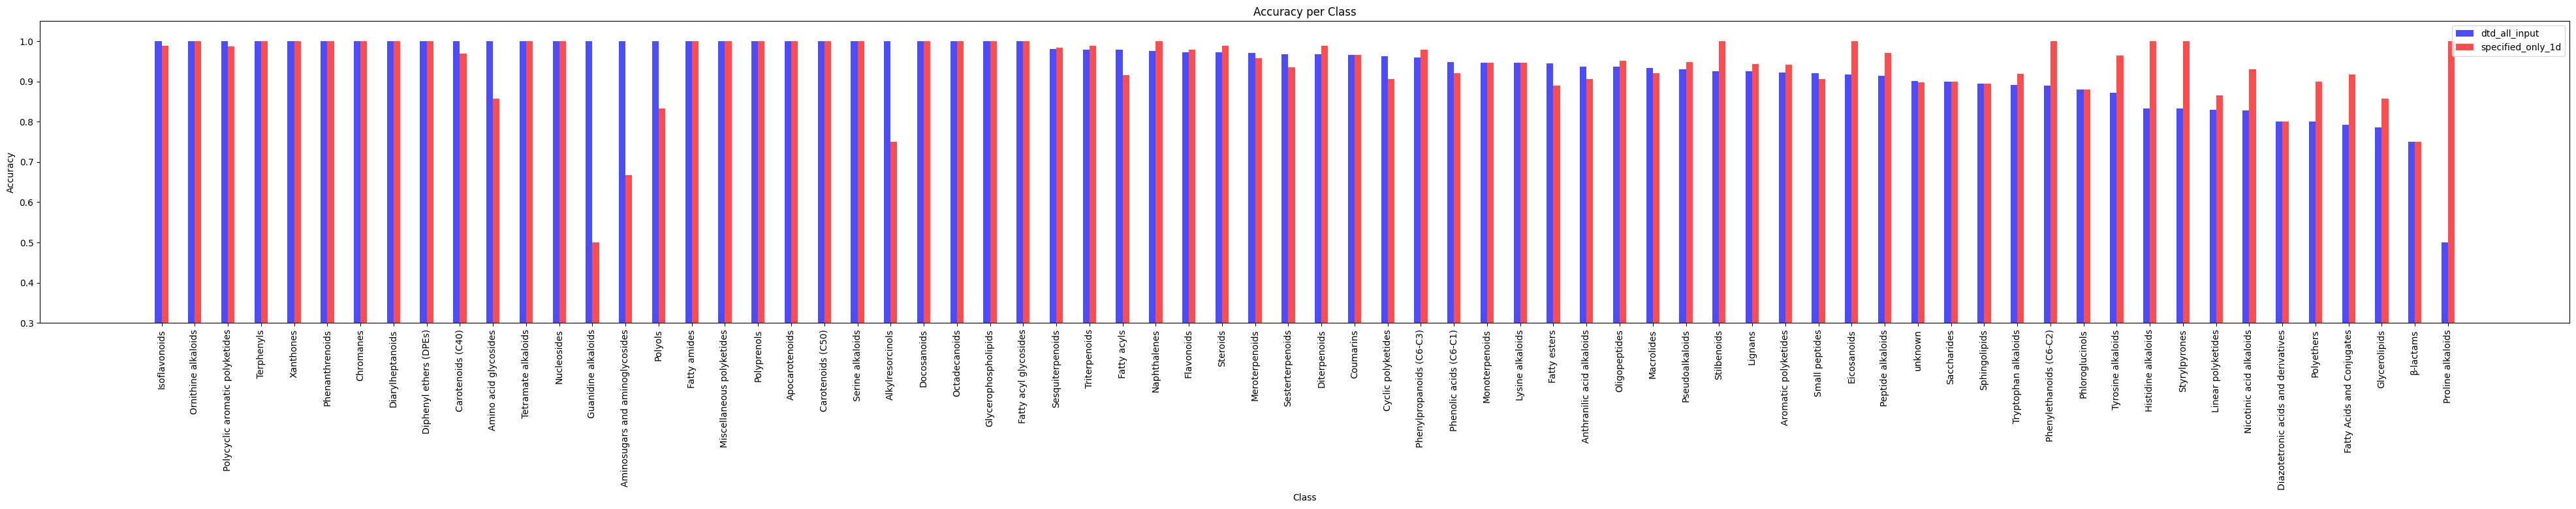

In [12]:
from utils.NP_classwise_accu_plot import compare_results_from_pkl_files

compare_results_from_pkl_files(
    "dtd_all_input",
    "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/flexible_models_best_FP/r0_r2_FP_trial_1/NP_class_accu_epoch=32-all_inputs.pkl",
    "specified_only_1d",
    "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_1d_trial_1/NP_class_accu_epoch=26-step=39393.pkl"
)

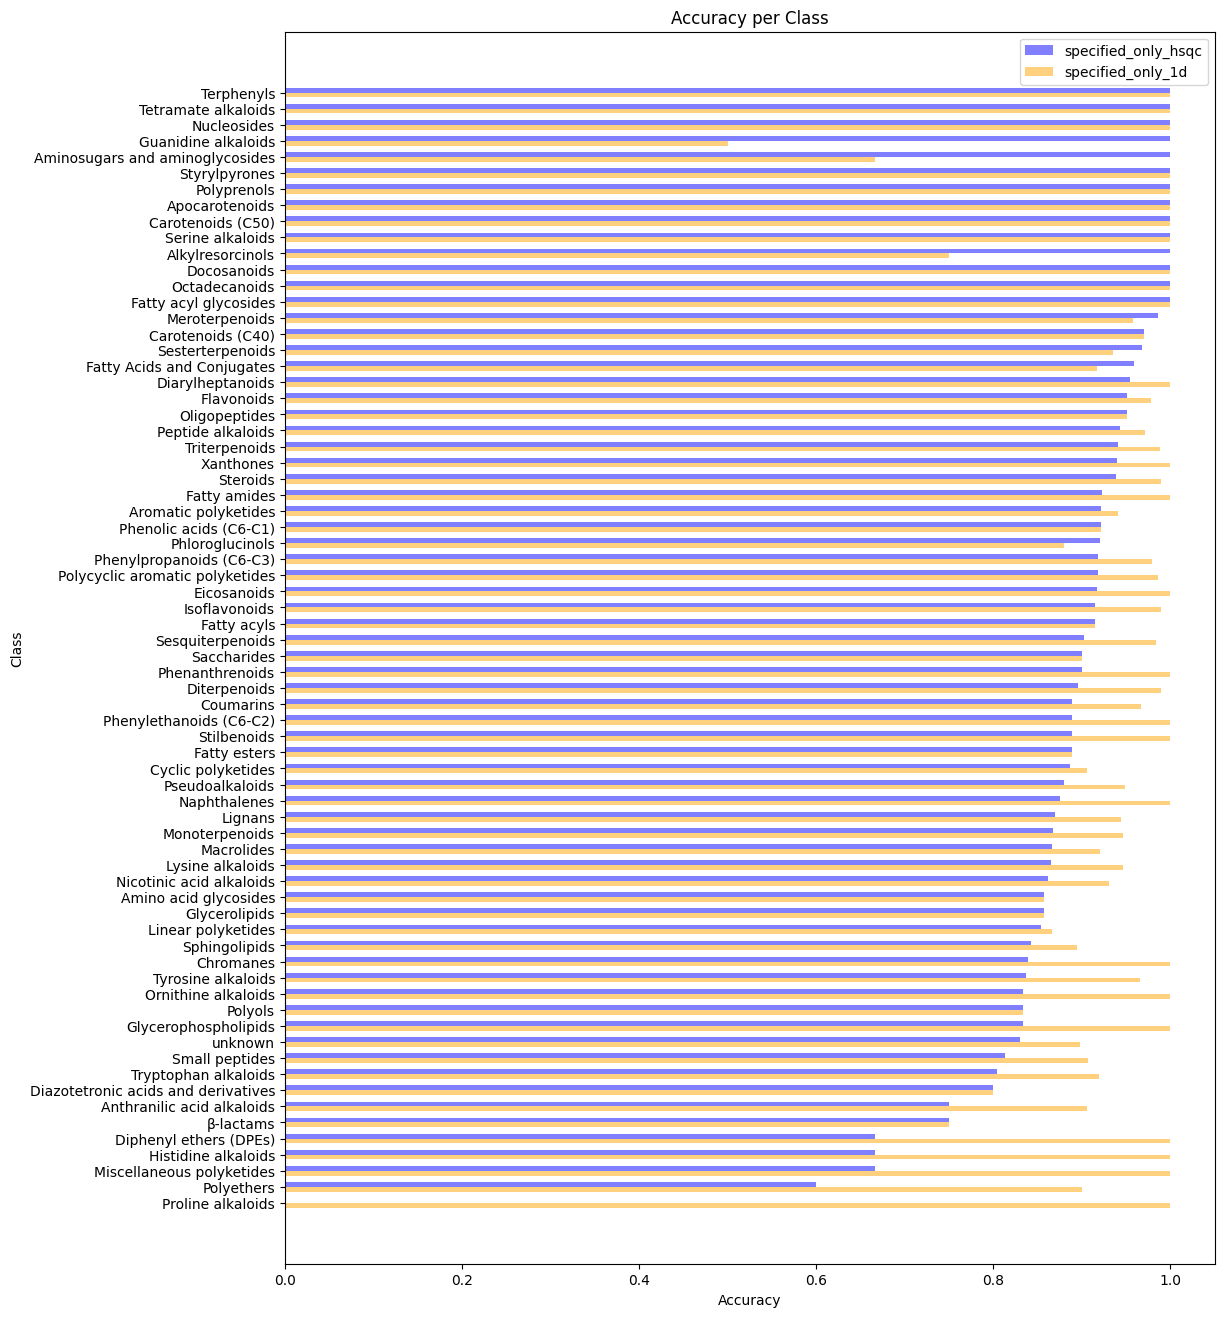

In [ ]:
compare_results_from_pkl_files(
    "specified_only_hsqc",
    "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_hsqc_trial_1/NP_class_accu_epoch=21-step=37708.pkl",
    "specified_only_1d",
    "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stable_argsort/train_on_all_data_possible/only_1d_trial_1/NP_class_accu_epoch=26-step=39393.pkl"
)

In [1]:
# tmp adjustment, wont be long term code
import pickle
def convert_test_result_pkl_to_multiple_pkls_for_each_nmr_type(test_result_pkl):
    with open(test_result_pkl, 'rb') as f:
        test_result = pickle.load(f)[0]
    
    for nmr_type in ["all_inputs", "only_C_NMR", "only_H_NMR", "only_hsqc", "only_1d", "HSQC_C_NMR", "HSQC_H_NMR"]:
        result = {k.split("/")[-2]: v for k, v in test_result.items() if k.startswith("test/rank_1_of_NP_class/") and k.endswith(nmr_type)}
        with open(f"{test_result_pkl.replace('.pkl', '')}_{nmr_type}.pkl", 'wb') as f:
            pickle.dump(result, f)
            


In [2]:
convert_test_result_pkl_to_multiple_pkls_for_each_nmr_type("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stop_on_cosine/larger_flexible_models_3072dim/r0_r2_FP_trial_3/test_result.pkl")

In [13]:
def convert_test_result_pkl_to_accu_pkl(test_result_pkl):
    with open(test_result_pkl, 'rb') as f:
        test_result = pickle.load(f)[0]
    
    
    result = {k.split("/")[-1]: v for k, v in test_result.items() if k.startswith("test/rank_1_of_NP_class/")}
    with open(f"{test_result_pkl.replace('.pkl', '')}_np_accu.pkl", 'wb') as f:
        pickle.dump(result, f)

In [ ]:

convert_test_result_pkl_to_accu_pkl("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stop_on_cosine/all_data_possible/all_info_trial_1/test_result.pkl")

In [16]:
import os
path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/stop_on_cosine/all_data_possible"
for folder in os.listdir(path):
    
        print(folder)
        convert_test_result_pkl_to_accu_pkl(f"{path}/{folder}/test_result.pkl")

only_hsqc_trial_1
HSQC_and_H_trial_1


HSQC_and_C_trial_1
only_h_trial_1
only_c_trial_1
all_info_trial_1
only_1d_trial_1
